In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

In [2]:
# jedi 0.14.1 tab completion fails; will be fixed in 0.14.2
import jedi
if jedi.__version__ == '0.14.1':
    %config Completer.use_jedi = False
    
# Progress bar
from tqdm.auto import trange, tqdm

In [3]:
import pynrc
from pynrc import nrc_utils, robust

In [4]:
from pynrc.detops import create_detops
from pynrc.reduce.ref_pixels import reffix_hxrg, channel_smooth_savgol, channel_averaging
from pynrc.nrc_utils import jl_poly_fit, jl_poly, hist_indices
from pynrc.simul.ngNRC import gen_col_noise, add_col_noise, gen_ramp_biases
from pynrc.simul.ngNRC import pink_noise, fft_noise, sim_noise_data, gen_dark_ramp, sim_dark_ramp
from pynrc.simul.ngNRC import add_ipc, add_ppc

from pynrc.reduce.calib import get_ipc_kernel, ipc_deconvolve, ppc_deconvolve
from pynrc.reduce.calib import get_fits_data, gen_super_bias, gen_super_dark
from pynrc.reduce.calib import chisqr_red, ramp_derivative, gen_col_variations
from pynrc.reduce.calib import gen_ref_dict#, get_bias_offsets, get_oddeven_offsets, get_ref_instability
from pynrc.reduce.calib import nircam_dark, plot_dark_histogram
from pynrc.reduce.calib import pow_spec_ramp, fit_corr_powspec, broken_pink_powspec
from pynrc.reduce.calib import get_power_spec, get_freq_array

In [5]:
import os, gzip, json
from copy import deepcopy
from astropy.io import fits
from scipy import ndimage

In [6]:
# Initialize
datadir='/Users/jarron/NIRCam/Data/CV3_Darks/'
outdir='/Users/jarron/NIRCam/dark_analysis/CV3/'
dark_data = nircam_dark(485, datadir, outdir)

[     pynrc:INFO] Initializing SCA 485/A5


In [7]:
# Get Super dark ramp (cube)
dark_data.get_super_dark_ramp()
# Calculate dark slope image
dark_data.get_dark_slope_image()
# Calculate pixel slope averages
dark_data.get_pixel_slope_averages()

[     pynrc:INFO] Generating inital super bias
[     pynrc:INFO] Creating super dark ramp cube, updated super bias, and pixel mask info
[     pynrc:INFO] Calculating dark slope image...
[     pynrc:INFO] Calculating average pixel ramps...


In [1]:
dark_data.get_cds_dict()
dark_data.get_power_spectrum(include_oh=False, mn_func=np.median)

NameError: name 'dark_data' is not defined

In [9]:
dark_data.get_ktc_noise()
dark_data.get_ipc(calc_ppc=True)
dark_data.deconvolve_supers()

[     pynrc:INFO] Calculating IPC and PPC kernels...
[     pynrc:INFO] IPC = 0.597% +/- 0.004%
[     pynrc:INFO] PPC = 0.123% +/- 0.010%


In [10]:
# Get column variations
dark_data.get_column_variations()
dark_data.get_ref_pixel_noise()

[     pynrc:INFO] Determining column variations (RTN)
[     pynrc:INFO] Determining reference pixel behavior


[     pynrc:INFO] Saving to /Users/jarron/NIRCam/dark_analysis/CV3/485/485_dark_ramp_avg.pdf


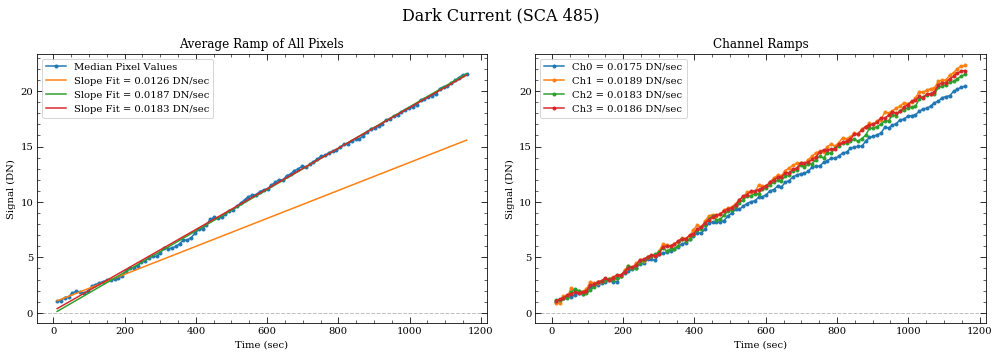

In [11]:
dark_data.plot_dark_ramps(save=True, time_cut=200)

[     pynrc:INFO] Saving to /Users/jarron/NIRCam/dark_analysis/CV3/485/485_dark_ramp_chans.pdf


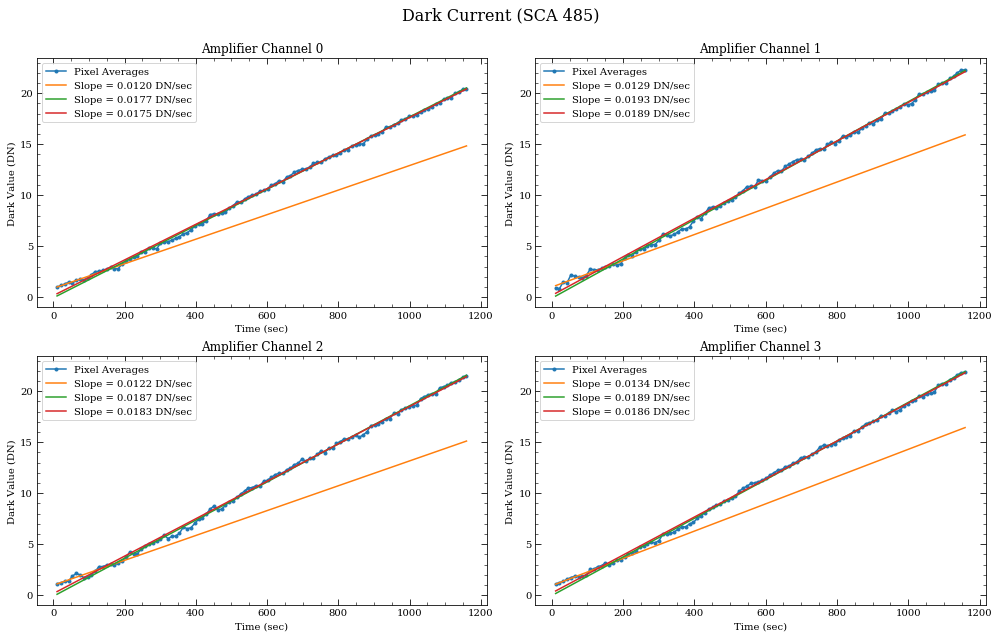

In [8]:
dark_data.plot_dark_ramps_ch(save=True, time_cut=200)

[     pynrc:INFO] Saving to /Users/jarron/NIRCam/dark_analysis/CV3/485/485_bias_dark_images.pdf


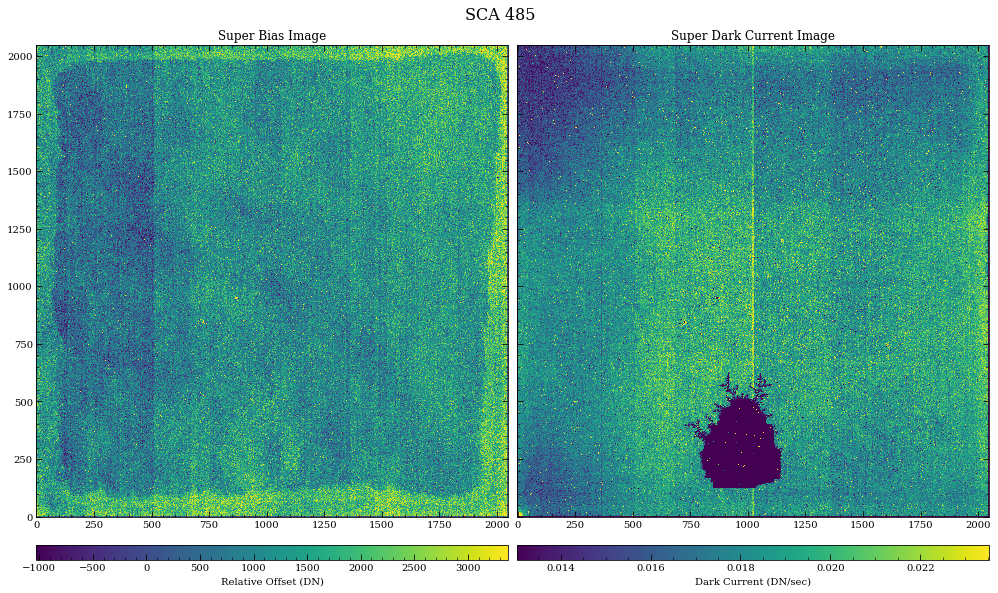

In [9]:
dark_data.plot_bias_darks(save=True)

[     pynrc:INFO] Saving to /Users/jarron/NIRCam/dark_analysis/CV3/485/485_dark_histogram.pdf


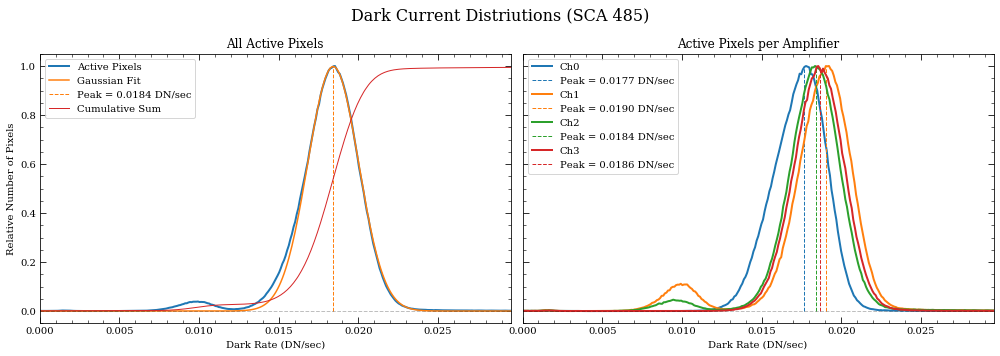

In [10]:
dark_data.plot_dark_distribution(save=True)

[     pynrc:INFO] Saving to /Users/jarron/NIRCam/dark_analysis/CV3/485/485_dark_overview.pdf


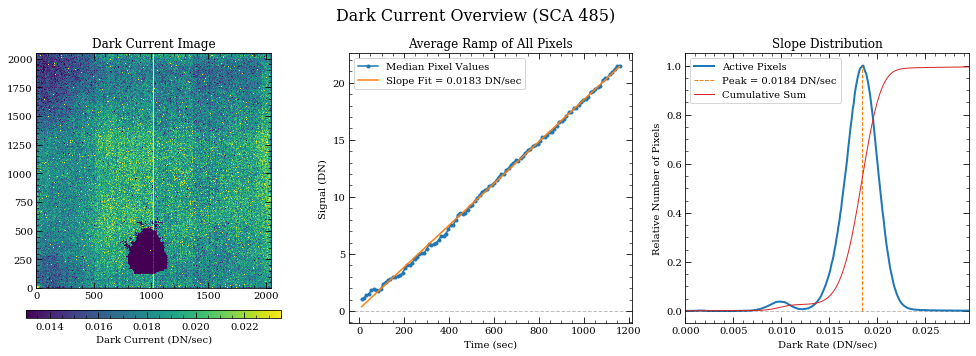

In [7]:
dark_data.plot_dark_overview(save=True)

[     pynrc:INFO] Saving to /Users/jarron/NIRCam/dark_analysis/CV3/485/485_bias_overview.pdf


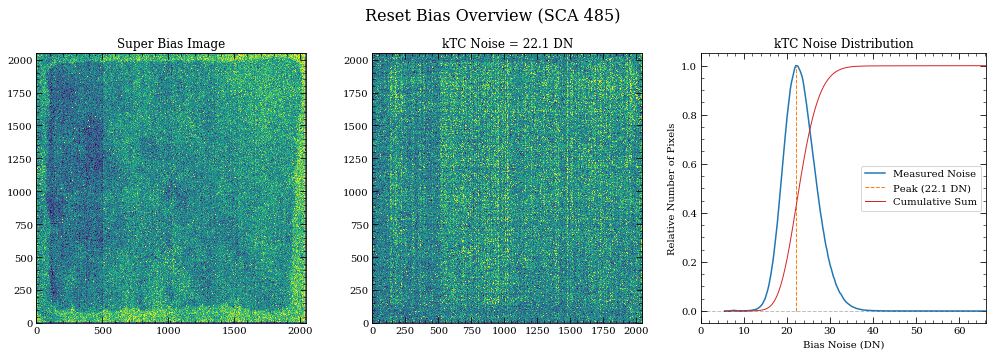

In [11]:
dark_data.plot_reset_overview(save=True)

[     pynrc:INFO] Saving to /Users/jarron/NIRCam/dark_analysis/CV3/485/485_cds_noise.pdf


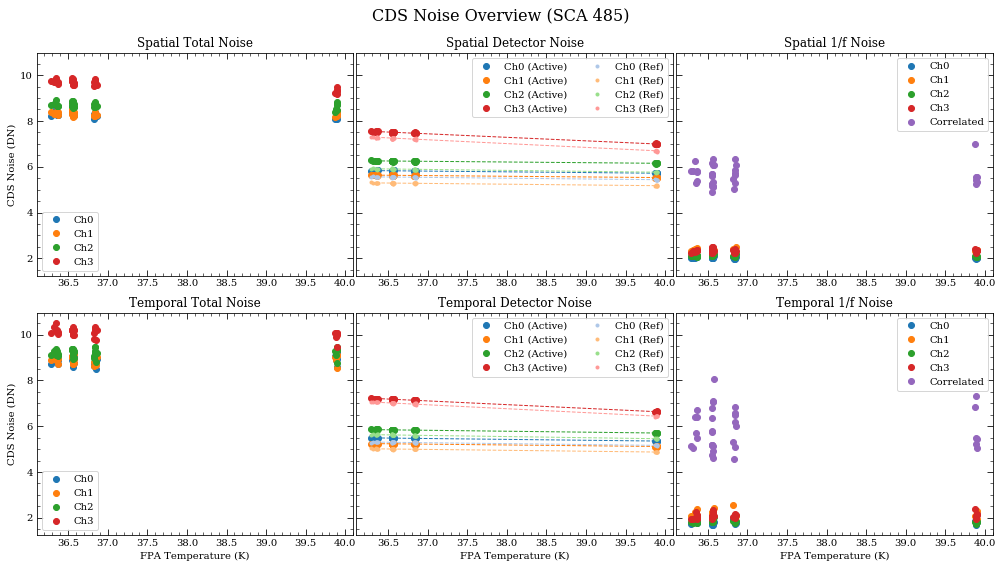

In [8]:
dark_data.plot_cds_noise(save=True)

[     pynrc:INFO] Saving to /Users/jarron/NIRCam/dark_analysis/CV3/485/485_power_spectra.pdf


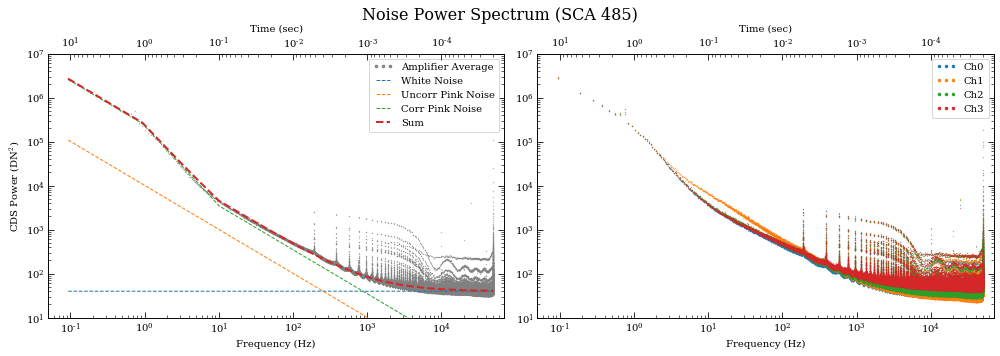

In [11]:
dark_data.plot_power_spectrum(save=True)

[     pynrc:INFO] Saving to /Users/jarron/NIRCam/dark_analysis/CV3/485/485_pixel_kernels.pdf


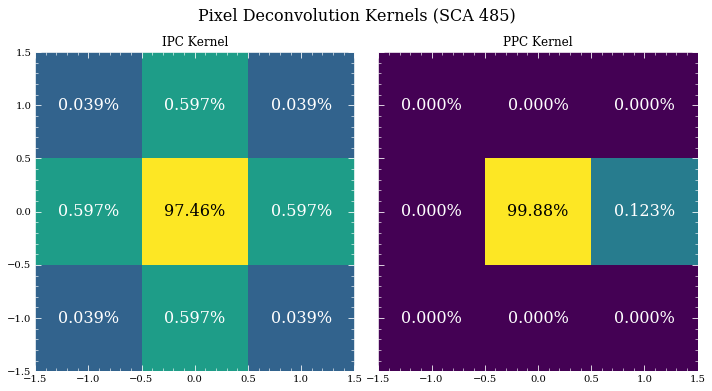

In [9]:
dark_data.plot_ipc_ppc(save=True)

In [11]:
self = dark_data

tarr = self.time_arr
det = self.det

nchan = det.nout
nx = det.xpix
ny = det.ypix
nz = det.multiaccum.ngroup
chsize = det.chsize

nroh = det._line_overhead
nfoh = det._extra_lines

# Channel size and ny plus pixel and row overheads
ch_poh = chsize + nroh
ny_poh = ny + nfoh


In [12]:
del self._super_dark_ramp
self._super_dark_ramp = None

In [16]:
cds_dict = self.cds_act_dict
keys = ['spat_det', 'spat_pink_corr', 'spat_pink_uncorr']
cds_vals = [np.sqrt(np.mean(cds_dict[k]**2, axis=0)) for k in keys]
rd_noise_cds, c_pink_cds, u_pink_cds = cds_vals

# print(np.sqrt(np.mean(np.mean(cds_dict['spat_tot']**2, axis=0))))
# print(np.sqrt(np.mean(np.mean(cds_dict['temp_tot']**2, axis=0))))

In [17]:
def calc_std_from_ps(ps):
    n_ifft = 2*(len(ps) - 1)
    w = ps[1:]
    w_last = ps[-1] * (1 + (n_ifft % 2)) / 2. # correct f = +-0.5
    the_std = np.sqrt(np.sum(w) + w_last) / np.sqrt(n_ifft / 2)

    return the_std

In [18]:
# Add in simulated noise
rn, cp, up = cds_vals / np.sqrt(2)

freq = self.pow_spec_dict['freq']
ps_all = self.pow_spec_dict['ps_all']


x = freq
y = np.mean(ps_all, axis=0)

yf = x**(0)
cds_var = np.mean(rd_noise_cds**2)
yf1 = len(yf) * cds_var * yf / yf.sum()

yf = x**(-1); yf[0]=0
cds_var = np.mean(u_pink_cds**2) / np.sqrt(2)
yf2 = len(yf) * cds_var * yf / yf.sum() 

yresid = y - yf2 - yf1
scales = fit_corr_powspec(x, yresid)
yf = broken_pink_powspec(x, scales)
cds_var = c_pink_cds**2
yf3 = len(yf) * cds_var * yf / yf.sum() / np.sqrt(2)

print(scales)

pcorr_fit = broken_pink_powspec(freq, scales)
# data = sim_noise_data(det, rd_noise=0, u_pink=0, c_pink=0,
#                        acn=0.1, pow_spec_corr=None)#pcorr_fit)

[227341.64376104  30687.17097153]


In [16]:
det.multiaccum.read_mode = 'RAPID'
det.wind_mode = 'STRIPE'
det.ypix = 512
det.multiaccum.ngroup = 10

In [17]:
super_bias = self.super_bias_deconv
super_dark = self.super_dark_deconv

k_ipc = self.kernel_ipc
k_ppc = self.kernel_ppc
ssd = self.same_scan_direction
rsd = self.reverse_scan_direction
ramp_avg_ch = self.dark_ramp_dict['ramp_avg_ch']

ref_ratio = np.mean(self.cds_ref_dict['spat_det'] / self.cds_act_dict['spat_det'])

kw_reffix = {
    'nchans': nchan, 'altcol': True, 'in_place': True,
    'fixcol': False, 'avg_type': 'pixel', 'savgol': True, 'perint': False
}

kw_powspec = {
    'nroh': nroh, 'nfoh': nfoh, 'nframes': 1,
    'same_scan_direction': ssd, 'reverse_scan_direction': rsd
}

In [23]:
%%time 
pynrc.setup_logging('INFO', verbose=False)
test = sim_noise_data(det, rd_noise=rn, u_pink=up, c_pink=cp*1.2,
                           acn=1, corr_scales=scales, ref_ratio=ref_ratio,
                           same_scan_direction=ssd, reverse_scan_direction=rsd)

[     pynrc:INFO] Generating read noise...
[     pynrc:INFO] Adding correlated pink noise...
[     pynrc:INFO] Adding uncorrelated pink noise...
[     pynrc:INFO] Adding ACN noise...
CPU times: user 4.56 s, sys: 430 ms, total: 4.99 s
Wall time: 4.99 s


In [18]:
det.y0

0

In [19]:
%time test = sim_dark_ramp(det, super_dark, gain=1.83, ramp_avg_ch=ramp_avg_ch)

[     pynrc:INFO] Generating dark current ramp...
(512, 512) (10, 512, 512)
(512, 512) (10, 512, 512)
(512, 512) (10, 512, 512)
(512, 512) (10, 512, 512)
CPU times: user 357 ms, sys: 33.7 ms, total: 391 ms
Wall time: 387 ms


0.2890700262342842


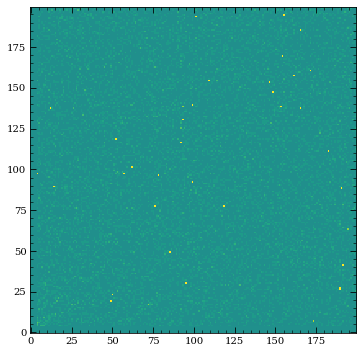

In [29]:
diff = test[2] - test[1]
print(robust.std(diff[:,4:500]))

mn = np.median(diff)
std = np.std(diff)
vmin = mn-3*std
vmax = mn+3*std

plt.imshow(diff[0:200,0:200], vmin=vmin, vmax=vmax)

In [20]:
pynrc.setup_logging('WARN', verbose=False)

super_bias = self.super_bias_deconv
super_dark = self.super_dark_deconv

k_ipc = self.kernel_ipc
k_ppc = self.kernel_ppc
ssd = self.same_scan_direction
rsd = self.reverse_scan_direction
ramp_avg_ch = self.dark_ramp_dict['ramp_avg_ch']

ref_ratio = np.mean(self.cds_ref_dict['spat_det'] / self.cds_act_dict['spat_det'])

kw_reffix = {
    'nchans': nchan, 'altcol': True, 'in_place': True,
    'fixcol': False, 'avg_type': 'pixel', 'savgol': True, 'perint': False
}

kw_powspec = {
    'nroh': nroh, 'nfoh': nfoh, 'nframes': 1,
    'same_scan_direction': ssd, 'reverse_scan_direction': rsd
}

ps_arr = []
for i in trange(1):
    
#     data = sim_noise_data(det, rd_noise=rn, u_pink=up, c_pink=cp, acn=1,
#                           pow_spec_corr=pcorr_fit)
#     data = reffix_hxrg(data, **kw_reffix)
#     ps, _, _ = get_power_spec(data, nchan=nchan, calc_cds=True, kw_powspec=kw_powspec)
#     ps_arr.append(ps)
    
    pbar = tqdm(total=10, leave=False)
    
    # Initialize data with dark current 
    pbar.set_description("Dark Current")
    data = sim_dark_ramp(det, super_dark, gain=1.83, ramp_avg_ch=ramp_avg_ch)
    pbar.update(1)
    
    # Add super bias
    pbar.set_description("Super Bias")
    data += super_bias
    pbar.update(1)

    # Add kTC noise:
    pbar.set_description("kTC Noise")
    ktc_noise = self.ktc_noise # Units of DN
    ktc_offset = np.random.normal(scale=ktc_noise, size=(ny,nx))
    data += ktc_offset
    pbar.update(1)
    
    # Apply IPC
    pbar.set_description("Include IPC")
    data = add_ipc(data, kernel=k_ipc)
    pbar.update(1)
    
    pbar.set_description("Detector Noise")
    data += sim_noise_data(det, rd_noise=rn, u_pink=up, c_pink=cp*1.2,
                           acn=1, pow_spec_corr=pcorr_fit, ref_ratio=ref_ratio,
                           same_scan_direction=ssd, reverse_scan_direction=rsd)
    pbar.update(1)
    
    # Add reference offsets
    pbar.set_description("Ref Pixel Instability")
    ref_dict = self._ref_pixel_dict
    data += gen_ramp_biases(ref_dict, data_shape=data.shape, ref_border=det.ref_info)
    pbar.update(1)

    # Add column noise
    pbar.set_description("Column Noise")
    col_noise = gen_col_noise(self.column_variations, self.column_prob_bad, nz=nz, nx=nx)
    data += col_noise
    pbar.update(1)

    # Apply PPC
    pbar.set_description("Include PPC")
    data = add_ppc(data, nchans=nchan, kernel=k_ppc, in_place=True,
                   same_scan_direction=ssd, reverse_scan_direction=rsd)
    pbar.update(1)
    
    # Convert to 16-bit int
    data[data < 0] = 0
    data[data >= 2**16] = 2**16 - 1
    data = data.astype('uint16')

    # Then back to float
    data = data.astype(np.float)
    
    # Ref pixel correction
    pbar.set_description("Ref Pixel Correction")
    data -= super_bias
    data = reffix_hxrg(data, **kw_reffix)
    pbar.update(1)
    
    pbar.set_description("Calc Power Spectrum")
    ps, _, _ = get_power_spec(data, nchan=nchan, calc_cds=True, kw_powspec=kw_powspec)
    pbar.update(1)
    
    ps_arr.append(ps)
    pbar.close()
    
ps_arr = np.array(ps_arr)

ps_sim = np.mean(ps_arr, axis=0)
freq_sim = get_freq_array(ps_sim, dt=1/det._pixel_rate)

ValueError: non-broadcastable output operand with shape (2048,2048) doesn't match the broadcast shape (10,2048,2048)

In [25]:
freq_sim.shape

(536839,)

8.001661150029388


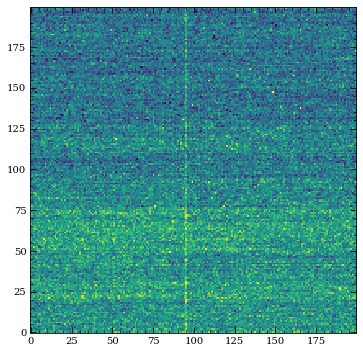

In [26]:
diff = data[2] - data[1]
print(robust.std(diff[:,4:500]))

mn = np.median(diff)
std = np.std(diff)
vmin = mn-3*std
vmax = mn+3*std

plt.imshow(diff[0:200,0:200], vmin=vmin, vmax=vmax)

39.75254860741584
(234033.42051883315, 27702.930895287747)


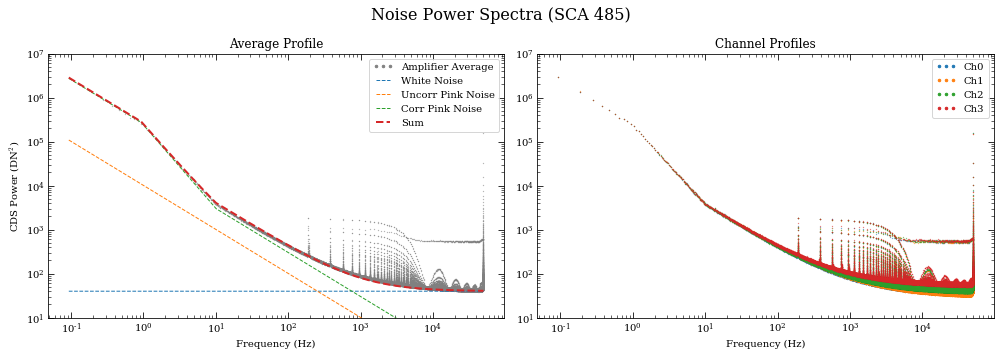

In [27]:
#save = True
scaid = self.scaid

fig, axes = plt.subplots(1,2, figsize=(14,5))

ax = axes[0]

x = freq_sim
y = np.mean(ps_sim, axis=0)
label='Amplifier Average'
ax.loglog(x[1:], y[1:], marker='o', ms=0.25, ls='none', color='grey', label=label)

# White Noise
yf = x**(0)
cds_var = np.mean(rd_noise_cds**2)
print(cds_var)
yf1 = len(yf) * cds_var * yf / yf.sum() 
ax.plot(x[1:], yf1[1:], ls='--', lw=1, label='White Noise')

# Pink Noise per Channel
yf = x**(-1); yf[0]=0
cds_var = np.mean(u_pink_cds**2) / np.sqrt(2)
yf2 = len(yf) * cds_var * yf / yf.sum()
ax.plot(x[1:], yf2[1:], ls='--', lw=1, label='Uncorr Pink Noise')

# Correlated Pink Noise
yresid = y - yf2 - yf1
scales = fit_corr_powspec(x, yresid)
print(scales)
yf = broken_pink_powspec(x, scales)
cds_var = c_pink_cds**2 / np.sqrt(2)
yf3 = len(yf) * cds_var * yf / yf.sum() 
ax.plot(x[1:], yf3[1:], ls='--', lw=1, label='Corr Pink Noise')

# Total of the three components
yf_sum = (yf1 + yf2 + yf3) 
ax.plot(x[1:], yf_sum[1:], ls='--', lw=2, label='Sum')

ax.set_ylabel('CDS Power (DN$^2$)')

ax = axes[1]

for ch in range(nchan):
    y = ps_sim[ch]
    ax.loglog(x[1:], y[1:], marker='o', ms=0.25, ls='none', label=f'Ch{ch}')

for ax in axes:
    ax.set_xlim([5e-2, 7e4])
    xloc = np.array(ax.get_xticks())
    xlim = ax.get_xlim()
    xind = (xloc>=xlim[0]) & (xloc<=xlim[1])
    ax.set_xlabel('Frequency (Hz)')

    ax.set_xlim(xlim)
    ax.set_ylim([10,1e7])
    ax.legend(numpoints=3, markerscale=10)

    ax2 = ax.twiny()
    ax2.set_xlim(1/np.array(xlim))
    ax2.set_xscale('log')
    ax2.set_xlabel('Time (sec)')
    # new_tick_locations = xloc[xind]
    # ax2.set_xticks(new_tick_locations)
    # ax2.set_xticklabels(tick_function(new_tick_locations))

    ax.minorticks_on()

fig.suptitle(f'Noise Power Spectra (Simulated Data)', fontsize=16)

fig.tight_layout()
fig.subplots_adjust(top=0.85)
    

In [26]:
#save = True
scaid = self.scaid

fig, axes = plt.subplots(1,2, figsize=(14,5))

ax = axes[0]

x = freq_sim
y = np.mean(ps_sim, axis=0)
label='Amplifier Average'
ax.loglog(x[1:], y[1:], marker='o', ms=0.25, ls='none', color='grey', label=label)

# White Noise
yf = x**(0)
cds_var = np.mean(rd_noise_cds**2)
print(cds_var)
yf1 = len(yf) * cds_var * yf / yf.sum() 
ax.plot(x[1:], yf1[1:], ls='--', lw=1, label='White Noise')

# Pink Noise per Channel
yf = x**(-1); yf[0]=0
cds_var = np.mean(u_pink_cds**2) / np.sqrt(2)
yf2 = len(yf) * cds_var * yf / yf.sum()
ax.plot(x[1:], yf2[1:], ls='--', lw=1, label='Uncorr Pink Noise')

# Correlated Pink Noise
yresid = y - yf2 - yf1
scales = fit_corr_powspec(x, yresid)
print(scales)
yf = broken_pink_powspec(x, scales)
cds_var = c_pink_cds**2 / np.sqrt(2)
yf3 = len(yf) * cds_var * yf / yf.sum() 
ax.plot(x[1:], yf3[1:], ls='--', lw=1, label='Corr Pink Noise')

# Total of the three components
yf_sum = (yf1 + yf2 + yf3) 
ax.plot(x[1:], yf_sum[1:], ls='--', lw=2, label='Sum')

ax.set_title('Average Profile')
ax.set_ylabel('CDS Power (DN$^2$)')

ax = axes[1]

x = freq
for ch in range(nchan):
    y = ps_sim[ch]
    ax.loglog(x[1:], y[1:], marker='o', ms=0.25, ls='none', label=f'Ch{ch}')

for ax in axes:
    ax.legend(numpoints=3, markerscale=10)
    ax.set_ylim([1e1,1e7])
    ax.set_xlabel('Frequency (Hz)')

ax.set_title('Channel Profiles')

fig.suptitle(f'Noise Power Spectra (SCA {scaid})', fontsize=16)

fig.tight_layout()
fig.subplots_adjust(top=0.85)
    

39.75254860741584
(238510.50966140363, 27787.50390799276)


In [25]:
#save = True
scaid = self.scaid

fig, axes = plt.subplots(1,2, figsize=(14,5))

ax = axes[0]

x = freq_sim
y = np.mean(ps_sim, axis=0)
label='Amplifier Average'
ax.loglog(x[1:], y[1:], marker='o', ms=0.1, ls='none', color='grey', label=label)

# White Noise
yf = x**(0)
cds_var = np.mean(rd_noise_cds**2)
print(cds_var)
yf1 = len(yf) * cds_var * yf / yf.sum() 
ax.plot(x[1:], yf1[1:], ls='--', lw=1, label='White Noise')

# Pink Noise per Channel
yf = x**(-1); yf[0]=0
cds_var = np.mean(u_pink_cds**2) / np.sqrt(2)
yf2 = len(yf) * cds_var * yf / yf.sum()
ax.plot(x[1:], yf2[1:], ls='--', lw=1, label='Uncorr Pink Noise')

# Correlated Pink Noise
yresid = y - yf2 - yf1
scales = fit_corr_powspec(x, yresid)
print(scales)
yf = broken_pink_powspec(x, scales)
cds_var = c_pink_cds**2 / np.sqrt(2)
yf3 = len(yf) * cds_var * yf / yf.sum() 
ax.plot(x[1:], yf3[1:], ls='--', lw=1, label='Corr Pink Noise')

# Total of the three components
yf_sum = (yf1 + yf2 + yf3) 
ax.plot(x[1:], yf_sum[1:], ls='--', lw=2, label='Sum')

ax.set_title('Average Profile')
ax.set_ylabel('CDS Power (DN$^2$)')

ax = axes[1]

for ch in range(nchan):
    y = ps_sim[ch]
    ax.loglog(x[1:], y[1:], marker='o', ms=0.1, ls='none', label=f'Ch{ch}')

for ax in axes:
    ax.legend(numpoints=3, markerscale=20)
    ax.set_ylim([1e1,1e7])
    ax.set_xlabel('Frequency (Hz)')

ax.set_title('Channel Profiles')

fig.suptitle(f'Noise Power Spectra (SCA {scaid})', fontsize=16)

fig.tight_layout()
fig.subplots_adjust(top=0.85)
    

39.75254860741584
(258229.91208231915, 29534.305513772815)


In [58]:
yresid = y-yf1
#yresid[x>1e4] = 0
calc_std_from_ps(yresid)

5.530427248827771

In [48]:
y - yf1

array([3990.21476445, 3876.94525298, 3542.70023667, ..., 3442.41997436,
       4730.1318229 , 5913.59030287])

In [52]:
arr = np.random.normal(scale=5, size=(10,2048,512))

ps_all_sim = []
for im in arr:
    npix = len(im.flatten())
    ps = np.abs(np.fft.rfft(im.flatten(),))**2 / npix
    ps_all_sim.append(ps)
ps_all_sim = np.array(ps_all_sim)
ps_mn_sim = np.mean(ps_all_sim, axis=0)
lin_all_sim = np.sqrt(ps_mn_sim)

In [53]:
np.median(lin_all_sim)

4.189193642582516

In [38]:
ps_all_sim.shape

(10, 524289)

In [39]:
ps_mn_sim = np.mean(ps_all_sim, axis=0)

In [ ]:
plt.

In [20]:
for ch in range(nchan):
    lin = np.sqrt(ps_sim[ch])
    print(rn[ch]*np.sqrt(2)/ np.median(lin), rn[ch]*np.sqrt(2) /np.sqrt(np.median(ps_sim[ch])), )

# plt.loglog(x,lin)

1.0194236297601167 1.0194236297601167
1.0182134936673124 1.0182134936673124
1.018630634489515 1.018630634489515
1.021177876401538 1.021177876401538


In [23]:
plt.loglog(freq_sim[1:], np.mean(ps_sim[:,1:], axis=0), marker=',', ls='none')
plt.ylim([1e1,1e7])

(10.0, 10000000.0)

In [15]:
ps_arr.shape

(4, 524289)

In [ ]:
data -= self.super_bias

kwargs = {
    'nchans': nchan, 'altcol': True, 'in_place': True,    
    'fixcol': False, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
}
data = reffix_hxrg(data, **kwargs)

In [9]:
# Frequency info
fs = det._pixel_rate
dt_pix =  1. / fs

# CDS Power spectrum
allfiles = self.allfiles
superbias = self.super_bias

nfiles = len(allfiles)

pow_spec_all = []
pow_spec_corr = []
# pow_spec_ucorr = []
# pow_spec_resid = []
for i in trange(nfiles):
    retf = True if i==0 else False

    f = allfiles[i]

    kwargs = {
        'nchans': nchan, 'altcol': True, 'in_place': True,    
        'fixcol': False, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
    }
    kwargs['fixcol'] = False
    data = get_fits_data(f, bias=superbias, reffix=True, **kwargs)
    
    # CDS
    cds = data[1::2] - data[0::2]
    # Remove averages from each frame
    cds_mn = np.median(cds.reshape([cds.shape[0], -1]), axis=1)
    cds -= cds_mn.reshape([-1,1,1])

    # Power spectrum of all frames data
    kwargs = {
        'return_freq': retf, 'dt': dt_pix, 
        'nroh': nroh, 'nfoh': nfoh, 'nframes': 1
    }
    res = pow_spec_ramp(cds, nchan, **kwargs)
    if i==0:
        ps, freq = res
        kwargs['return_freq'] = False
    else: 
        ps = res
    pow_spec_all.append(ps)
    

    # Remove correlated data
    
    # Extract 1/f noise from data
    fn_data = []
    for im in cds:
        ch_arr = im.reshape([ny,-1,chsize]).transpose([1,0,2])
        mask = np.abs(im - np.median(im)) > 10*robust.medabsdev(im)
        mask = mask.reshape([ny,-1,chsize]).transpose([1,0,2])
        fnoise = channel_smooth_savgol(ch_arr, mask=mask)
        fnoise = fnoise.transpose([1,0,2]).reshape([ny,nx])
        fn_data.append(fnoise)
    fn_data = np.array(fn_data)

    # Subtract from data
    cds -= fn_data
    
#     # Power spectrum of residual data
#     ps = pow_spec_ramp(cds, nchan)#, nfoh=nfoh, nroh=nroh)
#     pow_spec_resid.append(ps)
    del data, cds

    # Split into correlated and uncorrelated components
    fn_data_corr = []
    for j, im in enumerate(fn_data):
        fn_corr = channel_averaging(im, nchans=nchan,  off_chans=False,
            same_scan_direction=False, mn_func=np.mean)
        # Subtract from fn_data
        fn_data[j] -= fn_corr
        # Only append first channel since the rest are the same data
        fn_data_corr.append(fn_corr[:,0:chsize])
    fn_data_corr = np.array(fn_data_corr)
    
#     # Power spectrum of uncorrelated 1/f noise
#     ps = pow_spec_ramp(fn_data, nchan)#, nfoh=nfoh, nroh=nroh)
#     pow_spec_ucorr.append(ps)
    del fn_data

    # Power spectrum of correlated 1/f noise
    ps = pow_spec_ramp(fn_data_corr, 1, **kwargs)
    pow_spec_corr.append(ps)
    del fn_data_corr


pow_spec_all = np.array(pow_spec_all)
pow_spec_corr = np.array(pow_spec_corr)
# pow_spec_ucorr = np.array(pow_spec_ucorr)
# pow_spec_resid = np.array(pow_spec_resid)



In [16]:
# # Frequency array
# fs = det._pixel_rate
# dt =  1. / fs

# ps_all  = np.mean(pow_spec_all, axis=0)
# lin_all = np.sqrt(ps_all)

# npix_freq = ps_all.shape[-1]*2 - 1
# freq = np.fft.rfftfreq(npix_freq, d=dt)

In [16]:
df = freq[1] - freq[0]
ind = freq > freq.max() - df*10000
plt.semilogy(freq[ind], np.mean(ps_all[:,ind], axis=0))
plt.semilogy(freq[ind], ps_corr[ind])

In [45]:
ps_all  = np.mean(pow_spec_all, axis=0)
ps_corr = np.mean(pow_spec_corr, axis=0).squeeze()
# del pow_spec_all, pow_spec_corr

lin_all = np.sqrt(ps_all)
lin_corr = np.sqrt(ps_corr)

In [158]:
fig, axes = plt.subplots(1,2, figsize=(14,5))

ax = axes[0]

ch = 0

x = freq
y = np.mean(ps_all,axis=0)
ax.loglog(x[1:], y[1:], marker=',', ls='none', color='grey', alpha=0.5, label='Amplifier Average')

yf = x**(0)
cds_var = np.mean(rd_noise**2)
yf1 = len(yf) * cds_var * yf / yf.sum()
ax.plot(x[1:], yf1[1:], ls='--', lw=1, label='White Noise', alpha=0.5)
#ax.plot(x[1:], yf3[1:], ls='--', lw=1, label='white noise', alpha=0.5)

yf = x**(-1); yf[0]=0
cds_var = np.mean(u_pink**2)
yf2 = len(yf) * cds_var * yf / yf.sum() / np.sqrt(2)
ax.plot(x[1:], yf2[1:], ls='--', lw=1, label='Uncorr Pink Noise', alpha=0.5)

yresid = np.mean(ps_all, axis=0) - yf2 - yf1
scales = fit_corr_powspec(freq, yresid)
yf = broken_pink_powspec(freq, scales)
cds_var = c_pink**2
yf3 = len(yf) * cds_var * yf / yf.sum() / np.sqrt(2)
ax.plot(x[1:], yf3[1:], ls='--', lw=1, label='Corr Pink Noise', alpha=0.5)


yf_sum = (yf1 + yf2 + yf3) 
ax.plot(x[1:], yf_sum[1:], ls='--', lw=2, label='Sum')

# std_arr = []
# for yf in [yf1, yf2, yf3, yf_sum, np.mean(ps_all, axis=0)]:
#     lin_spec = np.sqrt(yf)
#     w = lin_spec[1:-1]
#     n_ifft = 2 * (len(lin_spec) - 1)
#     w_last = lin_spec[-1] * (1 + (n_ifft % 2)) / 2. # correct f = +-0.5
#     the_std = np.sqrt(2) * np.sqrt(np.sum(w**2) + w_last**2) / np.sqrt(n_ifft)
#     std_arr.append(the_std)
# print(std_arr)



ax = axes[1]

x = freq
for ch in range(nchan):
    y = ps_all[ch]
    ax.loglog(x[1:], y[1:], marker=',', ls='none', label=f'Ch{ch}')

for ax in axes:
    ax.legend(numpoints=3)
    ax.set_ylim([1e1,1e7])

    
fig.tight_layout()

In [132]:
# Compute the number of time steps per integration, per output
nstep_frame = ch_poh * ny_poh
nstep = nstep_frame * 1
# Pad nsteps to a power of 2, which is much faster
nstep2 = int(2**np.ceil(np.log2(nstep)))

f2 = np.fft.rfftfreq(2*nstep2)
f2[0] = f2[1] # First element should not be 0

yf2 = broken_pink_powspec(f2, scales)

In [145]:
# nstep_out = ny*chsize
# nstep2 = 2 * int(2**np.ceil(np.log2(nstep_out)))
# yf = pow_spec = f**alpha

%time out_noise = fft_noise(yf2, nstep_out=nstep_frame)
out_noise = out_noise.reshape([ny_poh, ch_poh])

CPU times: user 251 ms, sys: 18.2 ms, total: 269 ms
Wall time: 269 ms


In [147]:
%time out_noise = pink_noise(nstep, p_filter=yf2)
out_noise = out_noise.reshape([ny_poh, ch_poh])

CPU times: user 243 ms, sys: 20.9 ms, total: 264 ms
Wall time: 263 ms


In [140]:
yf2.shape

(2097153,)

In [142]:
out_noise.shape

(1073676,)

In [126]:
nstep_out = ny_poh * ch_poh
nstep = nstep_out
nstep2 = int(2**np.ceil(np.log2(nstep-1))) + 1

lin_spec = np.sqrt(yf2)
lin_spec[0] = lin_spec[1]

pad = nstep2-len(lin_spec)
lin_spec = np.pad(lin_spec, (pad,0), mode='edge')
                  
w = lin_spec[1:-1]
n_ifft = 2 * (len(lin_spec) - 1)
w_last = lin_spec[-1] * (1 + (n_ifft % 2)) / 2. # correct f = +-0.5
the_std = 2 * np.sqrt(np.sum(w**2) + w_last**2) / n_ifft

# Generate scaled random power + phase
sr = lin_spec
sr = np.random.normal(scale=lin_spec)
si = np.random.normal(scale=lin_spec)


si[0] = 0

# Combine power + corrected phase to Fourier components
thefft  = sr + 1J * si

# Apply the pinkening filter.
result = np.fft.irfft(thefft)
result = result[:nstep_out] / the_std

In [127]:
lin_spec

array([369.28459364, 369.28459364, 369.28459364, ...,   0.50401142,
         0.50401095,   0.50401048])

In [148]:
plt.imshow(out_noise)

In [32]:
alpha = -1.0
yf = freq**alpha
yf[0] = 0

ps_mean = np.mean(ps_all, axis=0)
ind = (freq >= 0) & (freq <= 1) & (ps_mean > 0)
scl1 = np.median(ps_mean[ind] / yf[ind])

ps_out = fit_corr_powspec(freq, ps_mean)

In [33]:
ps_out.shape

(536839,)

In [34]:
plt.loglog(freq, ps_all[0])
plt.loglog(freq, ps_corr[0])
plt.loglog(freq, ps_out)

In [ ]:
ps_

In [91]:
yf = fit_corr_powspec(freq, ps_corr[0])
yf = 2 * len(yf) * c_pink**2 * yf / yf.sum()

In [92]:
plt.loglog(freq[1:], np.mean(ps_all[:,1:], axis=0))
plt.loglog(freq[1:], yf[1:])

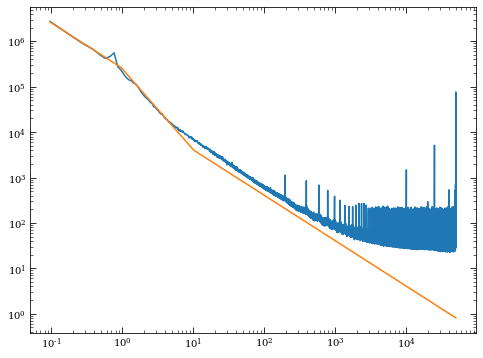

In [93]:
plt.loglog(freq[1:], ps_all[1,1:])
plt.loglog(freq[1:], test[1:])

In [42]:
yf = x**(0)
yf = 2*len(yf) * rd_noise[0]**2 * yf / yf.sum()

In [43]:
yf

array([33.69301149, 33.69301149, 33.69301149, ..., 33.69301149,
       33.69301149, 33.69301149])

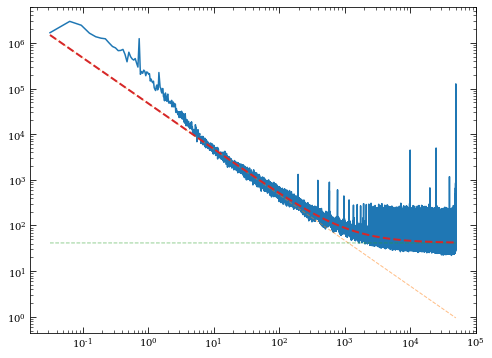

In [57]:
fig, ax = plt.subplots(1,1)

x = freq
y = np.mean(ps_all,axis=0)

ax.loglog(x[1:], y[1:],)

yf = x**(-1)
ind = (x>1e1) & (x<1e2)
scl = np.mean(y[ind] / yf[ind])
yf1 = scl*yf
ax.loglog(x[1:], yf1[1:], ls='--', lw=1, label='ucorr pink', alpha=0.5)

# yf = x**(-1.5)
# ind = (x>1e-2) & (x<1e0)
# scl = np.mean(y[ind] / yf[ind])
# yf2 = scl*yf
# ax.loglog(x[1:], yf2[1:], ls='--', lw=1, label='corr pink', alpha=0.5)

yf = x**(0)
ind = (x>1e4) & (x<4e4)
scl = np.mean(y[ind] / yf[ind])
yf3 = scl*yf
ax.loglog(x[1:], yf3[1:], ls='--', lw=1, label='white noise', alpha=0.5)

yf_sum = yf1 + yf3
ax.loglog(x[1:], yf_sum[1:], ls='--', lw=2, label='sum')



Generating dark current ramp...


Generating read noise...
Adding correlated pink noise...
Adding uncorrelated pink noise...


In [29]:
# Convert to 16-bit int
data[data < 0] = 0
data[data >= 2**16] = 2**16 - 1
data = data.astype('uint16')

# Then back to float
data = data.astype(np.float)

In [30]:
data -= self.super_bias

kwargs = {
    'nchans': nchan, 'altcol': True, 'in_place': True,    
    'fixcol': False, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
}
kwargs['fixcol'] = False
data = reffix_hxrg(data, **kwargs)

# Power spectrum of CDS data
cds = data[1::2] - data[0::2]

del data
ps_data = pow_spec_ramp(cds, nchan)
del cds

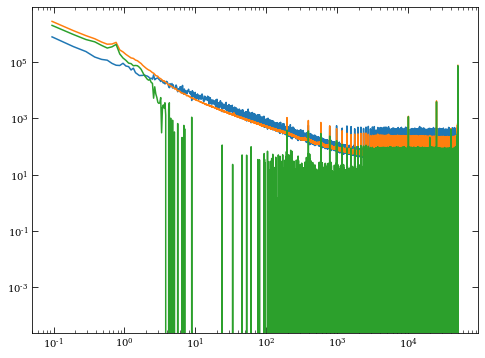

In [42]:
plt.loglog(freq[1:], np.mean(ps_all[:,1:], axis=0))
plt.loglog(freq[1:], np.mean(ps_data[:,1:], axis=0))
plt.loglog(freq[1:], np.mean(ps_all[:,1:], axis=0) - np.mean(ps_data[:,1:], axis=0))


In [31]:
ps_data.shape

(4, 524289)

In [95]:
# Frequency array
fs = det._pixel_rate
dt =  1. / fs

ps_all2  = np.mean(pow_spec_all2, axis=0)
lin_all2 = np.sqrt(ps_all2)

npix_freq = ps_all2.shape[-1]*2 - 1
freq2 = np.fft.rfftfreq(npix_freq, d=dt)

In [82]:
ps_all   = np.mean(pow_spec_all, axis=0)
# ps_resid = np.mean(pow_spec_resid, axis=0)
# ps_ucorr = np.mean(pow_spec_ucorr, axis=0)
# ps_corr  = np.mean(pow_spec_corr, axis=0).squeeze()

lin_all   = np.sqrt(ps_all)
# lin_resid = np.sqrt(ps_resid)
# lin_ucorr = np.sqrt(ps_ucorr)
# lin_corr  = np.sqrt(ps_corr)

In [83]:
# Frequency array
fs = det._pixel_rate
dt =  1. / fs

# Include overhead pixels
npix_freq = ps_all.shape[-1]*2 - 1
freq = np.fft.rfftfreq(npix_freq, d=dt)



In [84]:
freq.shape

(536839,)

In [81]:
lin_all.shape

(4, 536839)

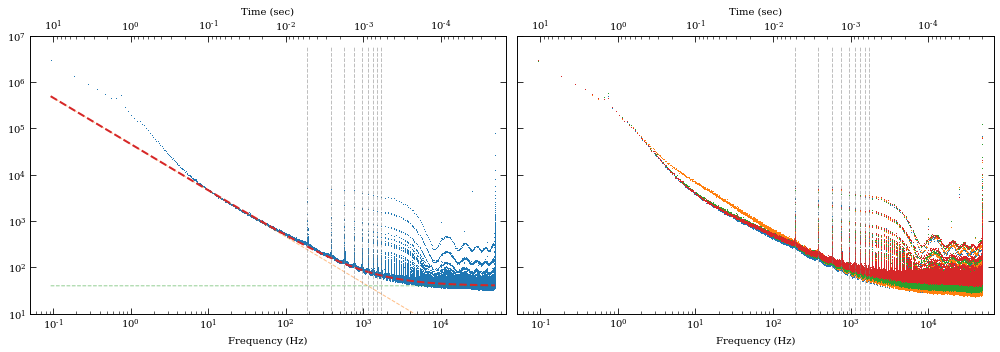

In [85]:
fig, axes = plt.subplots(1,2,figsize=(14,5), sharey=True)

carr = ['C0', 'C1', 'C2', 'C3']

x = freq

ax = axes[0]

y = np.mean(ps_all, axis=0)
ax.loglog(x[1:], y[1:], ls='none', marker=',')

yf = x**(-1)
ind = (x>1e1) & (x<1e2)
scl = np.mean(y[ind] / yf[ind])
yf1 = scl*yf
ax.loglog(x[1:], yf1[1:], ls='--', lw=1, label='ucorr pink', alpha=0.5)

# yf = x**(-1.5)
# ind = (x>1e-2) & (x<1e0)
# scl = np.mean(y[ind] / yf[ind])
# yf2 = scl*yf
# ax.loglog(x[1:], yf2[1:], ls='--', lw=1, label='corr pink', alpha=0.5)

yf = x**(0)
ind = (x>1e4) & (x<4e4)
scl = np.mean(y[ind] / yf[ind])
yf3 = scl*yf
ax.loglog(x[1:], yf3[1:], ls='--', lw=1, label='white noise', alpha=0.5)

yf_sum = yf1 + yf3
ax.loglog(x[1:], yf_sum[1:], ls='--', lw=2, label='sum')



############################

ax = axes[1]
for ch in np.arange(nchan):
    y = ps_all[ch]
    ax.loglog(x[1:], y[1:], color=carr[ch], ls='none', marker=',')

def tick_function(X):
    V = 1000. / X
    return ["%.3f" % z for z in V]
    
for ax in axes:
    ylim = ax.get_ylim()
#     ax.plot(2*[1. / det.time_frame], ylim, color='grey', ls='--', lw=1)
    lfreq = fs / ch_poh
    for j in range(10):
        ax.plot(2*[j*lfreq], ylim, color='grey', ls='--', lw=1, alpha=0.5)
#     wsize = 16 / det._pixel_rate
#     ax.plot(2*[1. / wsize], ylim, color='grey', ls='--', lw=1)    
    ax.set_ylim(ylim)

    
for ax in axes:
    ax.set_xlim([5e-2, 7e4])
    xloc = np.array(ax.get_xticks())
    xlim = ax.get_xlim()
    xind = (xloc>=xlim[0]) & (xloc<=xlim[1])
    new_tick_locations = xloc[xind]

    ax2 = ax.twiny()
    ax2.set_xlim(1/np.array(xlim))
    ax2.set_xscale('log')
#     ax2.set_xticks(new_tick_locations)
#     ax2.set_xticklabels(tick_function(new_tick_locations))
    
    ax.set_xlabel('Frequency (Hz)')
    ax2.set_xlabel('Time (sec)')
    
    ax.set_xlim(xlim)
    ax.set_ylim([10,1e7])
#     ax.legend()

fig.tight_layout()

In [89]:
freq

array([0.00000000e+00, 9.31378804e-02, 1.86275761e-01, ...,
       4.99997672e+04, 4.99998603e+04, 4.99999534e+04])

In [99]:
df = freq2[1] - freq2[0]
ind = (freq2>lfreq-100*df) & (freq2<lfreq+100*df)
y = np.mean(ps_all2, axis=0)
plt.plot(freq2[ind], y[ind])
plt.plot([lfreq,lfreq],[1000,5000])

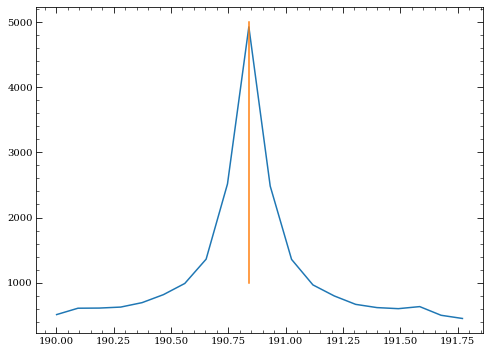

In [91]:
df = freq[1] - freq[0]
ind = (freq>lfreq-10*df) & (freq<lfreq+10*df)
y = np.mean(ps_all, axis=0)
plt.plot(freq[ind], y[ind])
plt.plot([lfreq,lfreq],[1000,5000])

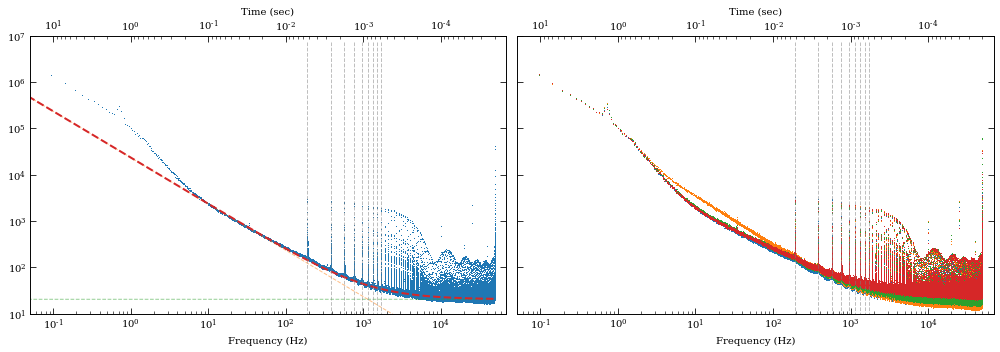

In [74]:
fig, axes = plt.subplots(1,2,figsize=(14,5), sharey=True)

carr = ['C0', 'C1', 'C2', 'C3']

x = freq

ax = axes[0]

y = np.mean(ps_all, axis=0)
ax.loglog(x[1:], y[1:], ls='none', marker=',')

yf = x**(-1)
ind = (x>1e1) & (x<1e2)
scl = np.mean(y[ind] / yf[ind])
yf1 = scl*yf
ax.loglog(x[1:], yf1[1:], ls='--', lw=1, label='ucorr pink', alpha=0.5)

# yf = x**(-1.5)
# ind = (x>1e-2) & (x<1e0)
# scl = np.mean(y[ind] / yf[ind])
# yf2 = scl*yf
# ax.loglog(x[1:], yf2[1:], ls='--', lw=1, label='corr pink', alpha=0.5)

yf = x**(0)
ind = (x>1e4) & (x<4e4)
scl = np.mean(y[ind] / yf[ind])
yf3 = scl*yf
ax.loglog(x[1:], yf3[1:], ls='--', lw=1, label='white noise', alpha=0.5)

yf_sum = yf1 + yf3
ax.loglog(x[1:], yf_sum[1:], ls='--', lw=2, label='sum')



############################

ax = axes[1]
for ch in np.arange(nchan):
    y = ps_all[ch]
    ax.loglog(x[1:], y[1:], color=carr[ch], ls='none', marker=',')

def tick_function(X):
    V = 1000. / X
    return ["%.3f" % z for z in V]
    
for ax in axes:
    ylim = ax.get_ylim()
#     ax.plot(2*[1. / det.time_frame], ylim, color='grey', ls='--', lw=1)
    lfreq = fs / ch_poh
    for j in range(10):
        ax.plot(2*[j*lfreq], ylim, color='grey', ls='--', lw=1, alpha=0.5)
#     wsize = 16 / det._pixel_rate
#     ax.plot(2*[1. / wsize], ylim, color='grey', ls='--', lw=1)    
    ax.set_ylim(ylim)

    
for ax in axes:
    ax.set_xlim([5e-2, 7e4])
    xloc = np.array(ax.get_xticks())
    xlim = ax.get_xlim()
    xind = (xloc>=xlim[0]) & (xloc<=xlim[1])
    new_tick_locations = xloc[xind]

    ax2 = ax.twiny()
    ax2.set_xlim(1/np.array(xlim))
    ax2.set_xscale('log')
#     ax2.set_xticks(new_tick_locations)
#     ax2.set_xticklabels(tick_function(new_tick_locations))
    
    ax.set_xlabel('Frequency (Hz)')
    ax2.set_xlabel('Time (sec)')
    
    ax.set_xlim(xlim)
    ax.set_ylim([10,1e7])
#     ax.legend()

fig.tight_layout()

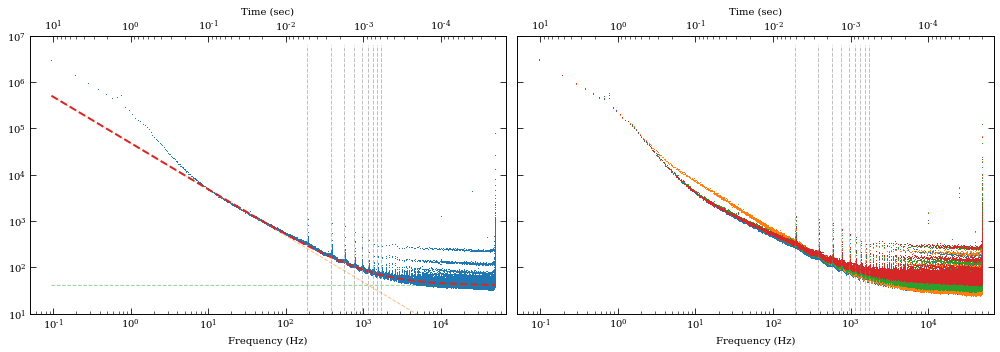

In [32]:
fig, axes = plt.subplots(1,2,figsize=(14,5), sharey=True)

carr = ['C0', 'C1', 'C2', 'C3']

x = freq

ax = axes[0]

y = np.mean(ps_all, axis=0)
ax.loglog(x[1:], y[1:], ls='none', marker=',')

yf = x**(-1)
ind = (x>1e1) & (x<1e2)
scl = np.mean(y[ind] / yf[ind])
yf1 = scl*yf
ax.loglog(x[1:], yf1[1:], ls='--', lw=1, label='ucorr pink', alpha=0.5)

# yf = x**(-1.5)
# ind = (x>1e-2) & (x<1e0)
# scl = np.mean(y[ind] / yf[ind])
# yf2 = scl*yf
# ax.loglog(x[1:], yf2[1:], ls='--', lw=1, label='corr pink', alpha=0.5)

yf = x**(0)
ind = (x>1e4) & (x<4e4)
scl = np.mean(y[ind] / yf[ind])
yf3 = scl*yf
ax.loglog(x[1:], yf3[1:], ls='--', lw=1, label='white noise', alpha=0.5)

yf_sum = yf1 + yf3
ax.loglog(x[1:], yf_sum[1:], ls='--', lw=2, label='sum')



############################

ax = axes[1]
for ch in np.arange(nchan):
    y = ps_all[ch]
    ax.loglog(x[1:], y[1:], color=carr[ch], ls='none', marker=',')

def tick_function(X):
    V = 1000. / X
    return ["%.3f" % z for z in V]
    
for ax in axes:
    ylim = ax.get_ylim()
#     ax.plot(2*[1. / det.time_frame], ylim, color='grey', ls='--', lw=1)
    lfreq = fs / ch_poh
    for j in range(10):
        ax.plot(2*[j*lfreq], ylim, color='grey', ls='--', lw=1, alpha=0.5)
#     wsize = 16 / det._pixel_rate
#     ax.plot(2*[1. / wsize], ylim, color='grey', ls='--', lw=1)    
    ax.set_ylim(ylim)

    
for ax in axes:
    ax.set_xlim([5e-2, 7e4])
    xloc = np.array(ax.get_xticks())
    xlim = ax.get_xlim()
    xind = (xloc>=xlim[0]) & (xloc<=xlim[1])
    new_tick_locations = xloc[xind]

    ax2 = ax.twiny()
    ax2.set_xlim(1/np.array(xlim))
    ax2.set_xscale('log')
#     ax2.set_xticks(new_tick_locations)
#     ax2.set_xticklabels(tick_function(new_tick_locations))
    
    ax.set_xlabel('Frequency (Hz)')
    ax2.set_xlabel('Time (sec)')
    
    ax.set_xlim(xlim)
    ax.set_ylim([10,1e7])
#     ax.legend()

fig.tight_layout()

In [21]:
def lin_fft_spec_std(lin_spec):
    
    w = lin_spec[1:-1]
    n_ifft = 2 * (len(lin_spec) - 1)
    w_last = lin_spec[-1] * (1 + (n_ifft % 2)) / 2. # correct f = +-0.5
    the_std = 2 * np.sqrt(np.sum(w**2) + w_last**2) / np.sqrt(n_ifft)

    return the_std

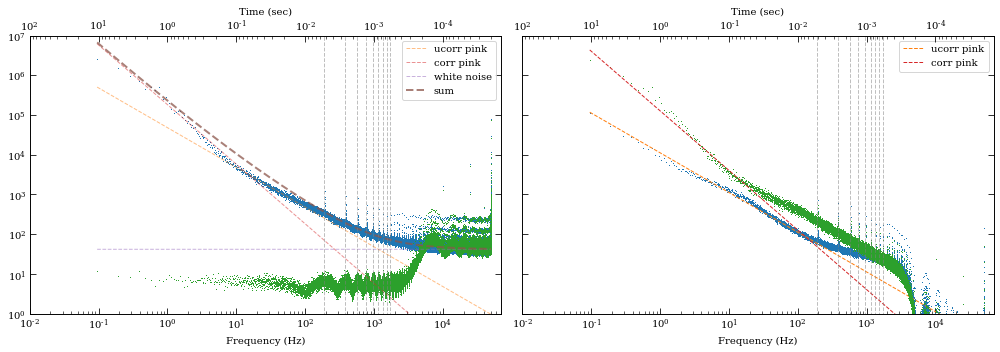

In [113]:
fig, axes = plt.subplots(1,2,figsize=(14,5), sharey=True)

carr = ['C0', 'C1', 'C2', 'C3']

x = freq

ax = axes[0]
# for ch in np.arange(nchan):
#     y = ps_all[ch, 1:]
#     ax.loglog(x, y, color=carr[ch], ls='none', marker=',')

y = np.mean(ps_all, axis=0)
ax.loglog(x[1:], y[1:], ls='none', marker=',')

yf = x**(-1)
ind = (x>1e1) & (x<1e2)
scl = np.mean(y[ind] / yf[ind])
yf1 = scl*yf
ax.loglog(x[1:], yf1[1:], ls='--', lw=1, label='ucorr pink', alpha=0.5)

y = np.mean(ps_resid, axis=0)
ax.loglog(x[1:], y[1:], ls='none', marker=',')

yf = x**(-1.5)
y = np.mean(ps_all, axis=0)
ind = (x>1e-2) & (x<1e0)
scl = np.mean(y[ind] / yf[ind])
yf2 = scl*yf
ax.loglog(x[1:], yf2[1:], ls='--', lw=1, label='corr pink', alpha=0.5)

yf = x**(0)
ind = (x>1e4) & (x<4e4)
scl = np.mean(y[ind] / yf[ind])
yf3 = scl*yf
ax.loglog(x[1:], yf3[1:], ls='--', lw=1, label='white noise', alpha=0.5)

yf_sum = yf1 + yf2 + yf3
ax.loglog(x[1:], yf_sum[1:], ls='--', lw=2, label='sum', alpha=0.75)

############################

ax = axes[1]
# for ch in np.arange(nchan):
#     y = ps_resid[ch, 1:]
#     ax.loglog(x, y, color=carr[ch], ls='none', marker=',')

y = np.mean(ps_ucorr, axis=0)
ax.loglog(x[1:], y[1:], ls='none', marker=',')

yf = x**(-1)
ind = (x>1e1) & (x<1e2)
scl = np.mean(y[ind] / yf[ind])
ax.loglog(x[1:], scl*yf[1:], ls='--', lw=1, label='ucorr pink')

y = ps_corr
ax.loglog(x[1:], y[1:], ls='none', marker=',')

yf = x**(-1.5)
ind = (x>1e-2) & (x<1e1)
scl = np.mean(y[ind] / yf[ind])
ax.loglog(x[1:], scl*yf[1:], ls='--', lw=1, label='corr pink')

 
def tick_function(X):
    V = 1000. / X
    return ["%.3f" % z for z in V]

    
for ax in axes:
    ylim = ax.get_ylim()
#     ax.plot(2*[1. / det.time_frame], ylim, color='grey', ls='--', lw=1)
    lfreq = fs / ch_poh
    for j in range(10):
        ax.plot(2*[j*lfreq], ylim, color='grey', ls='--', lw=1, alpha=0.5)
#     wsize = 16 / det._pixel_rate
#     ax.plot(2*[1. / wsize], ylim, color='grey', ls='--', lw=1)    
    ax.set_ylim(ylim)

    
for ax in axes:
    ax.set_xlim([1e-2, 7e4])
    xloc = np.array(ax.get_xticks())
    xlim = ax.get_xlim()
    xind = (xloc>=xlim[0]) & (xloc<=xlim[1])
    new_tick_locations = xloc[xind]

    ax2 = ax.twiny()
    ax2.set_xlim(1/np.array(xlim))
    ax2.set_xscale('log')
#     ax2.set_xticks(new_tick_locations)
#     ax2.set_xticklabels(tick_function(new_tick_locations))
    
    ax.set_xlabel('Frequency (Hz)')
    ax2.set_xlabel('Time (sec)')
    
    ax.set_xlim(xlim)
    ax.set_ylim([1,1e7])
    ax.legend()

fig.tight_layout()

In [81]:
sig_vals = np.array([lin_fft_spec_std(y) for y in lin_all])
print("full", sig_vals)
sig_vals = np.array([lin_fft_spec_std(y) for y in lin_resid])
print("resid", sig_vals)
print("corr", lin_fft_spec_std(lin_corr))
sig_vals = np.array([lin_fft_spec_std(y) for y in lin_ucorr])
print("ucorr", sig_vals)

full [10.97956513 11.23910383 11.49473411 12.54546218]
resid [ 8.22988282  8.29593302  8.83319128 10.0977128 ]
corr 6.742661417896816
ucorr [2.45849118 2.83357167 2.52857129 2.79083391]


In [58]:
test = np.mean(lin_all, axis=0) * np.sqrt(ny*chsize)
res = np.fft.irfft(test)
res = res.reshape([ny,chsize])

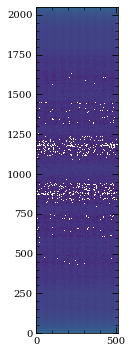

In [62]:
plt.imshow(res**0.2)

In [178]:
npix = ny_poh*ch_poh
npix = ny*chsize

nstep2 = int(2**np.ceil(np.log2(npix)))
f = np.fft.rfftfreq(2*nstep2)
f[0] = f[1]
p_filter = np.sqrt(f**(-1.0))
p_filter[0] = 0.

In [173]:

%time test = pink_noise(npix, p_filter)
print(test.std())


# Frequency array
fs = det._pixel_rate
dt =  1. / fs
freq = np.fft.rfftfreq(npix, d=dt)

ps = np.abs(np.fft.rfft(test.flatten()))**2

2097153 1073676
lin_spec 1: 2097153
lin_spec 2: 2097153
result 1: 4194304
result 2: 1073676
(1073676,)
CPU times: user 243 ms, sys: 26.7 ms, total: 270 ms
Wall time: 267 ms
1.0310712938941182


In [181]:

%time test = pink_noise(npix)#, p_filter)
print(test.std())


# Frequency array
fs = det._pixel_rate
dt =  1. / fs
freq = np.fft.rfftfreq(npix, d=dt)

ps = np.abs(np.fft.rfft(test.flatten()))**2

1048577 1048576
lin_spec 1: 1048577
lin_spec 2: 1048577
result 1: 2097152
result 2: 1048576
(1048576,)
CPU times: user 130 ms, sys: 19.4 ms, total: 149 ms
Wall time: 147 ms
0.9736823109877959


In [182]:
ps.shape

(524289,)

In [183]:
plt.loglog(freq[1:], ps[1:])

In [184]:
plt.imshow(test.reshape([ny,-1]))

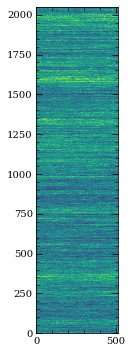

In [164]:
plt.imshow(test.reshape([ny,-1]))

In [73]:
test2 = pink_noise2(20*npix)
print(test2.std())

1.0407387314422616


In [69]:
test2.shape

(262144,)

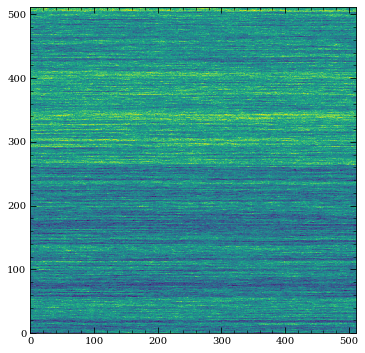

In [38]:
plt.imshow(test2.reshape([512,512]))

In [32]:
def pink_noise2(nstep, f=None, p_filter=None, nstep2=None, fmin=None, alpha=-1):
    """Generate a vector of non-periodic pink noise.

    Parameters
    ----------
    f : 1D ndarray
        Frequencies from `np.fft.rfftfreq` assuming dt=1.
        This is usually padded to a have a number of 
        elements that are a power of 2 (plus +1), which
        helps with processing speed.
    p_filter : 1D ndarray
        Pinkening filter. Same size as `f`.
    nstep : int
        Number of elements in final result. Must be a number
        smaller or equal to size of `f`.
    nstep2 : int
        Number of input elements used when generating `f`.
        This is usually a number padded to a power of 2 to
        improve speed.
    fmin : float, optional
        Low-frequency cutoff. A value of 0 means no cut-off.
        
    Example
    -------
    
    """

    # Configure depending on mode setting
#     if 'pink' in mode:
#         nstep  = 2*self.nstep
#         nstep2 = 2*self.nstep2
#         f = self.f2
#         p_filter = self.p_filter2
#     elif 'acn' in mode:
#         nstep  = self.nstep
#         nstep2 = self.nstep2
#         f = self.f1
#         p_filter = self.p_filter1
#     elif 'ref_inst' in mode:
#         nstep  = 2*self.naxis3
#         nstep2 = 2*self.naxis3
#         f = self.f3
#         p_filter = self.p_filter3

    # Pad nsteps to a power of 2, which is much faster
    if nstep2 is None:
        nstep2 = int(2**np.ceil(np.log2(nstep)))
    if f is None:
        f = np.fft.rfftfreq(nstep2)
        f[0] = f[1] # First element should not be 0
    if p_filter is None:
        p_filter = np.sqrt(f**alpha)
        p_filter[0] = 0.

    # Build scaling factors for all frequencies
    fmin = 1./nstep2 if fmin is None else np.max([fmin, 1./nstep2])
    ix  = np.sum(f < fmin)   # Index of the cutoff
    if ix > 1 and ix < len(f):
        f = f.copy()
        p_filter = p_filter.copy()
        f[:ix] = f[ix]
        p_filter[:ix] = p_filter[ix]

    # Calculate theoretical output standard deviation from scaling
    w = p_filter[1:-1]
    w_last = p_filter[-1] * (1 + (nstep2 % 2)) / 2. # correct f = +-0.5
    n_ifft = 2 * (len(p_filter) - 1)
    the_std = 2 * np.sqrt(np.sum(w**2) + w_last**2) / n_ifft

    # Generate scaled random power + phase
    sr = np.random.normal(scale=p_filter)
    si = np.random.normal(scale=p_filter)

    # If the signal length is even, frequencies +/- 0.5 are equal
    # so the coefficient must be real.
    if (nstep2 % 2) == 0: 
        si[-1] = 0

    # Regardless of signal length, the DC component must be real
    si[0] = 0

    # Combine power + corrected phase to Fourier components
    thefft  = sr + 1J * si

    #p0 = time.time()
    # Apply the pinkening filter.
    result = np.fft.irfft(thefft)

    #p1 = time.time()
    #print("FFT and IFFT took",p1-p0," seconds")

    # Keep 1st half of nstep and scale to unit variance
    result = result[:nstep//2] / the_std

    return result


In [410]:
npix = 2048*2048
nstep2 = npix

f = np.fft.rfftfreq(npix)

psarr = []
for n in trange(5):
    sig = np.random.randn(npix)*10
    ps = np.abs(np.fft.rfft(sig))**2 / npix
    psarr.append(ps)
psarr = np.array(psarr)
lin = np.sqrt(np.mean(psarr, axis=0))
print(np.mean(lin))
# lin[:] = 10

ind = f>1e-2

lin_spec = lin#*np.sqrt(npix)

w = lin_spec[1:-1]
w_last = lin_spec[-1] * (1 + (nstep2 % 2)) / 2. # correct f = +-0.5
the_std = np.sqrt(2 * (np.sum(w**2) + w_last**2)) / nstep2
print(the_std)

res = np.fft.irfft(lin_spec) / the_std

print(np.std(sig), np.std(res))




9.753027096200302
0.0048826368288257685
9.996965188609837 1.0000000586209283


In [411]:
psarr.shape

(5, 2097153)

In [504]:
ps_mean = np.mean(psarr, axis=0)

npix = 1000
nstep_out=npix**2
print(nstep_out)
%time res = fft_noise(ps_mean, nstep_out=nstep_out)

res = res.reshape([npix,npix])
print(np.std(res))

1000000
CPU times: user 239 ms, sys: 17.7 ms, total: 256 ms
Wall time: 256 ms
0.999067204434293


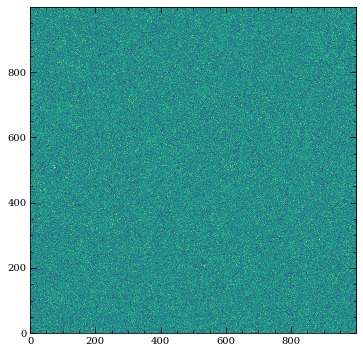

In [505]:
plt.imshow(res)

In [494]:
n_ifft = 2097153
f = np.fft.rfftfreq(n_ifft)


In [495]:
f[1]-f[0]

4.76836930829558e-07

In [496]:
1 / n_ifft

4.76836930829558e-07

In [466]:
%time ires = np.abs(np.fft.irfft(res))**2

CPU times: user 406 µs, sys: 249 µs, total: 655 µs
Wall time: 438 µs


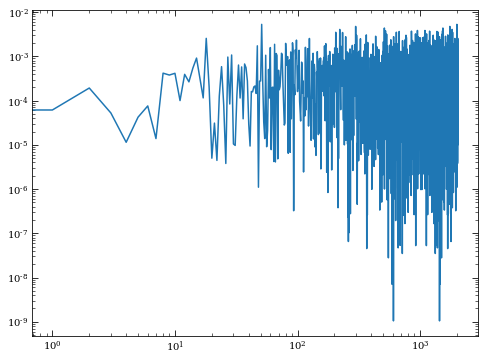

In [467]:
plt.loglog(ires)

In [375]:
ps[:] = 10
res = fft_noise(ps, nstep_out=npix)
res = res.reshape([2048,2048])

ps = np.abs(np.fft.rfft(res.flatten()))**2 #/ npix
f = np.fft.rfftfreq(npix)

6476.344648024841
4194304 4194304
4.47213502203922
(8388606,)
(4194304,)


In [371]:
test = pink_noise(512*512)

In [474]:
sig = np.random.randn(62)

the_fft = np.fft.rfft(sig)
print(len(the_fft))

nstep = len(the_fft)
nstep2 = int(2**np.ceil(np.log2(nstep-1))) + 1

print(nstep, nstep2)

32
32 33


In [376]:
np.std(res)

0.7067860329322442

In [349]:
plt.loglog(f,ps)

In [454]:
def pink_noise(nstep, f=None, p_filter=None, nstep2=None, fmin=None, alpha=-1):
    """Generate a vector of non-periodic pink noise.

    Parameters
    ----------
    f : 1D ndarray
        Frequencies from `np.fft.rfftfreq` assuming dt=1.
        This is usually padded to a have a number of 
        elements that are a power of 2 (plus +1), which
        helps with processing speed.
    p_filter : 1D ndarray
        Pinkening filter. Same size as `f`.
    nstep : int
        Number of elements in final result. Must be a number
        smaller or equal to size of `f`.
    nstep2 : int
        Number of input elements used when generating `f`.
        This is usually a number padded to a power of 2 to
        improve speed.
    fmin : float, optional
        Low-frequency cutoff. A value of 0 means no cut-off.
        
    Example
    -------
    
    """

    # Configure depending on mode setting
#     if 'pink' in mode:
#         nstep  = 2*self.nstep
#         nstep2 = 2*self.nstep2
#         f = self.f2
#         p_filter = self.p_filter2
#     elif 'acn' in mode:
#         nstep  = self.nstep
#         nstep2 = self.nstep2
#         f = self.f1
#         p_filter = self.p_filter1
#     elif 'ref_inst' in mode:
#         nstep  = 2*self.naxis3
#         nstep2 = 2*self.naxis3
#         f = self.f3
#         p_filter = self.p_filter3

    # Pad nsteps to a power of 2, which is much faster
    if nstep2 is None:
        nstep2 = int(2**np.ceil(np.log2(nstep)))
    if f is None:
        f = np.fft.rfftfreq(nstep2)
        f[0] = f[1] # First element should not be 0
    if p_filter is None:
        p_filter = np.sqrt(f**alpha)
        p_filter[0] = 0.

    # Build scaling factors for all frequencies
    fmin = 1./nstep2 if fmin is None else np.max([fmin, 1./nstep2])
    ix  = np.sum(f < fmin)   # Index of the cutoff
    if ix > 1 and ix < len(f):
        f = f.copy()
        p_filter = p_filter.copy()
        f[:ix] = f[ix]
        p_filter[:ix] = p_filter[ix]

    # Calculate theoretical output standard deviation from scaling
    w = p_filter[1:-1]
    w_last = p_filter[-1] * (1 + (nstep2 % 2)) / 2. # correct f = +-0.5
    n_ifft = 2 * (len(p_filter) - 1)
    the_std = 2 * np.sqrt(np.sum(w**2) + w_last**2) / n_ifft

    # Generate scaled random power + phase
    sr = np.random.normal(scale=p_filter)
    si = np.random.normal(scale=p_filter)

    # If the signal length is even, frequencies +/- 0.5 are equal
    # so the coefficient must be real.
    if (nstep2 % 2) == 0: 
        si[-1] = 0

    # Regardless of signal length, the DC component must be real
    si[0] = 0

    # Combine power + corrected phase to Fourier components
    thefft  = sr + 1J * si

    #p0 = time.time()
    # Apply the pinkening filter.
    result = np.fft.irfft(thefft)

    #p1 = time.time()
    #print("FFT and IFFT took",p1-p0," seconds")

    # Keep 1st half of nstep and scale to unit variance
    result = result[:nstep//2] / the_std

    return result


In [13]:
def sim_noise_data(det, rd_noise=[5,5,5,5], c_pink=3, u_pink=[1,1,1,1],
             same_scan_direction=False, reverse_scan_direction=False):
    
    """
    
    same_scan_direction : bool
        Are all the output channels read in the same direction?
        By default fast-scan readout direction is ``[-->,<--,-->,<--]``
        If ``same_scan_direction``, then all ``-->``
    reverse_scan_direction : bool
        If ``reverse_scan_direction``, then ``[<--,-->,<--,-->]`` or all ``<--``

    """
    
    nchan = det.nout
    nx = det.xpix
    ny = det.ypix
    nz = det.multiaccum.ngroup
    chsize = det.chsize

    nroh = det._line_overhead
    nfoh = det._extra_lines
    
    result = np.zeros([nz,ny,nx])
                            
    # Make white read noise. This is the same for all pixels.
    if rd_noise is not None:
        # We want rd_noise to be an array or list
        if isinstance(rd_noise, (np.ndarray,list)):
            temp = np.asarray(rd_noise)
            if temp.size != nchan:
                print('Number of elements in rd_noise not equal to n_out')
                return
        else: # Single value as opposed to an array or list
            rd_noise = np.ones(nchan) * rd_noise
    
        w = det.ref_info
        rr = 0.8 #reference_pixel_noise_ratio  # Easier to work with
        
        if np.any(rd_noise):
            print('Generating read noise...')
            # Go frame-by-frame
            for z in np.arange(nz):
                here = np.zeros((ny,nx))

                # First assume no ref pixels and just add in random noise
                for ch in np.arange(nchan):
                    x1 = ch * chsize
                    x2 = x1 + chsize
                    here[:,x1:x2] = np.random.normal(scale=rd_noise[ch], size=(ny,chsize))

                # If there are reference pixels, overwrite with appropriate noise values
                # Noisy reference pixels for each side of detector
                rd_ref = rr * np.mean(rd_noise)
                if w[0] > 0: # lower
                    here[:w[0],:] = np.random.normal(scale=rd_ref, size=(w[0],nx))
                if w[1] > 0: # upper
                    here[-w[1]:,:] = np.random.normal(scale=rd_ref, size=(w[1],nx))
                if w[2] > 0: # left
                    here[:,:w[2]] = np.random.normal(scale=rd_ref, size=(ny,w[2]))
                if w[3] > 0: # right
                    here[:,-w[3]:] = np.random.normal(scale=rd_ref, size=(ny,w[3]))

                # Add the noise in to the result
                result[z,:,:] += here
                
    # Finish if no 1/f noise specified
    if (c_pink is None) and (u_pink is None):
        return result
                
    #################################
    # 1/f noise
        
    ch_poh = chsize + nroh
    ny_poh = ny + nfoh

    # Compute the number of time steps per integration, per output
    nstep_frame = ch_poh * ny_poh
    nstep = nstep_frame * nz
    # Pad nsteps to a power of 2, which is much faster
    nstep2 = int(2**np.ceil(np.log2(nstep)))
    
    f2 = np.fft.rfftfreq(2*nstep2)
    f2[0] = f2[1] # First element should not be 0
    alpha = -1
    p_filter2 = np.sqrt(f2**alpha)
    p_filter2[0] = 0.
    
    # Add correlated pink noise.
    if (c_pink is not None) and (c_pink > 0):
        print('Adding correlated pink noise...')

        tt = c_pink * pink_noise(2*nstep, f=f2, p_filter=p_filter2, nstep2=2*nstep2)
        tt = tt.reshape([nz, ny_poh, ch_poh])[:,0:ny,0:chsize]
        # tt = tt.reshape([nz, ny_poh, ch_poh])[:,0:ny,0:chsize]
        for ch in np.arange(nchan):
            x1 = ch*chsize
            x2 = x1 + chsize
            
            if same_scan_direction:
                flip = True if reverse_scan_direction else False
            elif np.mod(ch,2)==0:
                flip = True if reverse_scan_direction else False
            else:
                flip = False if reverse_scan_direction else True

            if flip: 
                result[:,:,x1:x2] += tt[:,:,::-1]
            else:
                result[:,:,x1:x2] += tt
        del tt

    # Add uncorrelated pink noise. Because this pink noise is stationary and
    # different for each output, we don't need to flip it (but why not?)
    if u_pink is not None:
        # We want u_pink to be an array or list
        if isinstance(u_pink, (np.ndarray,list)):
            temp = np.asarray(u_pink)
            if temp.size != nchan:
                print('Number of elements in u_pink not equal to n_out')
                return
        else: # Single value as opposed to an array or list
            u_pink = np.ones(nchan) * u_pink

        # Only do the rest if any values are not 0
        if np.any(u_pink):
            print('Adding uncorrelated pink noise...')
            
            for ch in trange(nchan):
                x1 = ch*chsize
                x2 = x1 + chsize

                tt = c_pink * pink_noise(2*nstep, f=f2, p_filter=p_filter2, nstep2=2*nstep2)
                tt = tt.reshape([nz, ny_poh, ch_poh])[:,0:ny,0:chsize]
                # tt = tt.reshape([nz, ny_poh, ch_poh])[:,0:ny,0:chsize]

                if same_scan_direction:
                    flip = True if reverse_scan_direction else False
                elif np.mod(ch,2)==0:
                    flip = True if reverse_scan_direction else False
                else:
                    flip = False if reverse_scan_direction else True

                if flip: 
                    result[:,:,x1:x2] += tt[:,:,::-1]
                else:
                    result[:,:,x1:x2] += tt

                del tt

    return result

In [14]:
def gen_dark_ramp(dark, out_shape, tf=10.73677, gain=1, ref_info=None,
                  avg_ramp=None):
    
    """
    Assumes a constant dark current rate, either in image form or single value.
    Dark is assumed to be in e-/sec. 
    
    If gain is supplied, then input is DN/sec. Output will be in same units.
    """

    nz, ny, nx = out_shape
    
    # Create an array to house differential signals
    result = np.zeros([nz,ny,nx])
        
    dark_frame = np.ones([ny,nx]) * dark * tf

    # Set negative values to median
    med = np.median(dark_frame)
    med = 0 if med<0 else med
    dark_frame[dark_frame<0] = med

    if np.any(dark_frame):
        print('Generating dark current ramp...')

        # For each read frame, create random dark current instance
        dark_temp = np.zeros([ny,nx])
        for z in np.arange(nz):
            # Add delta dark increment with Poisson
            dark_temp += np.random.poisson(dark_frame*gain, size=None) / gain
            result[z,:,:] += dark_temp

    # Modulate perfect slope by "average ramp" behavior
    if avg_ramp is not None:
        tarr = np.arange(1,nz+1)*tf
        avg_dark = np.median(dark)
        del_ramp = avg_ramp - avg_dark*tarr
        result += del_ramp.reshape([-1,1,1])
            
    # Set reference pixels' dark current equal to 0
    if ref_info is not None:
        w = ref_info
        if w[0] > 0: # lower
            result[:,:w[0],:] = 0
        if w[1] > 0: # upper
            result[:,-w[1]:,:] = 0
        if w[2] > 0: # left
            result[:,:,:w[2]] = 0
        if w[3] > 0: # right
            result[:,:,-w[3]:] = 0
            
    # Return in units of DN
    return result 

In [15]:
def sim_dark_ramp(det, super_dark, ramp_avg_ch=None, gain=1, ref_info=[4,4,4,4]):
    
    nchan = det.nout
    nx = det.xpix
    ny = det.ypix
    nz = det.multiaccum.ngroup
    chsize = det.chsize
    tf = det.time_frame
    
    res = np.zeros([nz,ny,nx])
    for ch in np.arange(nchan):
        x1, x2 = ch*chsize, (ch+1)*chsize
        dark = super_dark[:,x1:x2]
        
        avg_ramp = None if ramp_avg_ch is None else ramp_avg_ch[ch]
        res[:,:,x1:x2] = gen_dark_ramp(dark, (nz,ny,chsize), gain=gain, tf=tf,
                                       avg_ramp=avg_ramp, ref_info=None)
        
    # Set reference pixels' dark current equal to 0
    if ref_info is not None:
        w = ref_info
        if w[0] > 0: # lower
            res[:,:w[0],:] = 0
        if w[1] > 0: # upper
            res[:,-w[1]:,:] = 0
        if w[2] > 0: # left
            res[:,:,:w[2]] = 0
        if w[3] > 0: # right
            res[:,:,-w[3]:] = 0

        
    return res
        

In [16]:
def pow_spec(data, nchan, mn_func=np.median, nroh=0, nfoh=0,
             return_freq=False, dt=1):
    
    nz, ny, nx = data.shape
    chsize = int(nx / nchan)

    # Channel size and ny plus pixel and row overheads
    ch_poh = chsize + nroh
    ny_poh = ny + nfoh
    
    ps_data = []
    for ch in range(nchan):
        # Array of pixel values
        if (nroh>0) or (nfoh>0):
            sig = np.zeros([nz,ny_poh,ch_poh])
            sig[:,0:ny,0:chsize] += data[:,:,ch*chsize:(ch+1)*chsize]
        else:
            sig = data[:,:,ch*chsize:(ch+1)*chsize]
            
        if np.mod(ch,2)==1: # Flip x-axis for odd channels
            sig = sig[:,:,::-1]
        sig = sig.reshape([sig.shape[0],-1])
        npix = sig.shape[1]

        # Power spectrum
        ps = np.abs(np.fft.rfft(sig))**2 / npix
        # Average of all power spectra
        ps_data.append(mn_func(ps, axis=0))
        
    ps_data = np.array(ps_data)
    
    if return_freq:
        freq = np.fft.rfftfreq(npix, d=dt)
        return ps_data, freq
    else:
        return ps_data 


In [255]:
ps = np.mean(ps_mean, axis=0)
ps_new = np.zeros_like(ps) + 5**2

lfreq = fs / ch_poh
df = freq[2] - freq[1]
nmax = np.ceil(freq.max() / lfreq).astype(int)
for j in np.arange(1,nmax+1):
    f = j*lfreq
    ind = (freq>f-30*df) & (freq<f+30*df)
    ind_fit = ((freq>f-60*df) & (freq<f-30*df)) | ((freq<f+60*df) & (freq>f+30*df))
    cf = jl_poly_fit(freq[ind_fit], ps[ind_fit])
    ps_new[ind] += ps[ind] - jl_poly(freq[ind], cf)
    
# Add ACN
ind = freq>freq.max()-1000*df
ps_new[ind] = ps[ind]

ps_new[ps_new<0] = 0

npix_poh = ch_poh*ny_poh

lin_arr = np.sqrt(ps_new * npix_poh)
# wn = 10 * np.sqrt(npix_poh)
# lin_arr += np.random.normal(scale=wn, size=lin_arr.shape)
lin_arr = np.random.normal(scale=lin_arr)
result = np.fft.irfft(lin_arr)

In [148]:
p_filter = np.sqrt(freq**(-1))
p_filter[0] = 0.


In [149]:
plt.loglog(freq, p_filter)

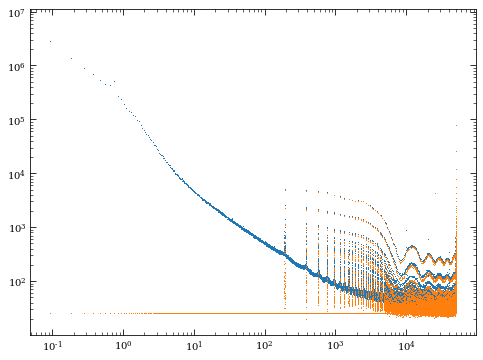

In [256]:
plt.loglog(freq, ps, ls='none', marker=',')
plt.loglog(freq, ps_new, ls='none', marker=',')

In [181]:
ch = 0
sig = np.zeros([nz//2,ny_poh,ch_poh])
sig[:,0:ny,0:chsize] += cds[:,:,ch*chsize:(ch+1)*chsize]
sig = sig.reshape([sig.shape[0],-1])
npix = sig.shape[1]

the_fft = np.fft.rfft(sig)


In [196]:
fft_real = np.real(the_fft)
fft_pos = fft_real.copy()
fft_pos[fft_pos<0] = 0
fft_neg = fft_real.copy()
fft_neg[fft_neg>0] = 0
fft_neg *= -1

fft_pos[fft_pos==0] = np.min(fft_pos[fft_pos!=0])
fft_neg[fft_neg==0] = np.min(fft_neg[fft_neg!=0])

In [258]:
result = result.reshape([ny_poh,ch_poh])

In [259]:
np.std(result)

5.137188383735122

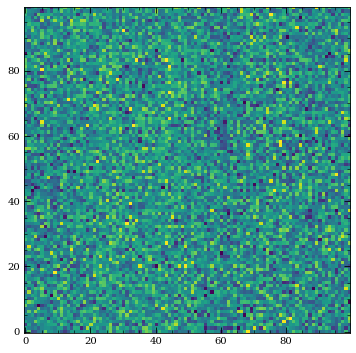

In [261]:
im = result[0:100,0:100]
mn = np.median(im)
std = np.std(im)
vmin = mn - 3*std
vmax = mn + 3*std
plt.imshow(im, vmin=vmin, vmax=vmax)

In [110]:
df = freq[1] - freq[0]
ind = (freq>5*lfreq-30*df) & (freq<5*lfreq+30*df)
ind = (freq>1e4-100*df) & (freq<1e4+100*df)
plt.semilogy(freq[ind],ps[ind], marker=',', ls='none')
plt.semilogy(freq[ind],ps_new[ind], marker=',', ls='none')

In [52]:
freq[2]-freq[1]

0.09313796713347415

In [ ]:
y = np.median(ps_mean, axis=0) 
plt.loglog(freq[1:], y[1:], ls='none', marker=',')
    
# ind = freq>1e4
# print(np.median(lin_mean[:,ind], axis=1))

Generating dark current ramp...
Generating dark current ramp...
Generating dark current ramp...
Generating dark current ramp...
CPU times: user 18.5 s, sys: 2.74 s, total: 21.3 s
Wall time: 21.3 s


In [105]:
del data
data = np.zeros([nz,ny,nx])

Generating read noise...
Adding correlated pink noise...
Adding uncorrelated pink noise...



CPU times: user 1min 37s, sys: 23.6 s, total: 2min 1s
Wall time: 2min 1s


In [108]:
data -= self.super_bias

kwargs = {
    'nchans': nchan, 'altcol': True, 'in_place': True,    
    'fixcol': False, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
}
kwargs['fixcol'] = False
data = reffix_hxrg(data, **kwargs)

# Power spectrum of CDS data
data = data[1::2] - data[0::2]
ps_data = pow_spec(data, nchan)

# Subtract average dark ramp
# data -= self.super_dark_ramp

# Subtract slope fits
# cf = jl_poly_fit(tarr, data)
# data -= jl_poly(tarr,cf)

In [91]:
# Frequency array
fs = det._pixel_rate
dt =  1. / fs

npix_ch = chsize*ny
freq = np.fft.rfftfreq(npix_ch, d=dt)

In [103]:
y = np.median(ps_data, axis=0) 
plt.loglog(freq[1:], y[1:], ls='none', marker=',')

# ind = freq>1e4
# print(np.median(lin_mean[:,ind], axis=1))

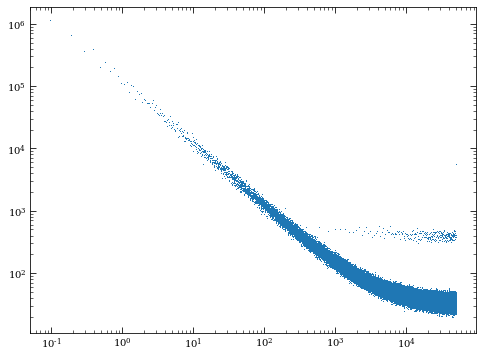

In [109]:
y = np.median(ps_data, axis=0) 
plt.loglog(freq[1:], y[1:], ls='none', marker=',')
    
# ind = freq>1e4
# print(np.median(lin_mean[:,ind], axis=1))

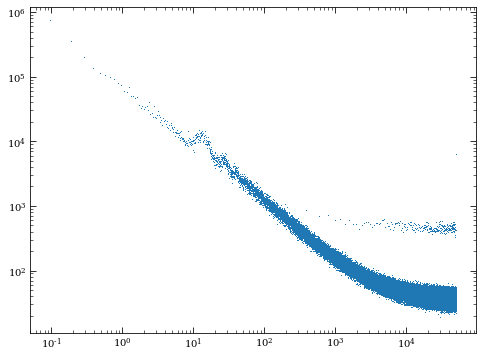

In [34]:
y = np.median(ps_data, axis=0) 
plt.loglog(freq[1:], y[1:], ls='none', marker=',')
    
# ind = freq>1e4
# print(np.median(lin_mean[:,ind], axis=1))

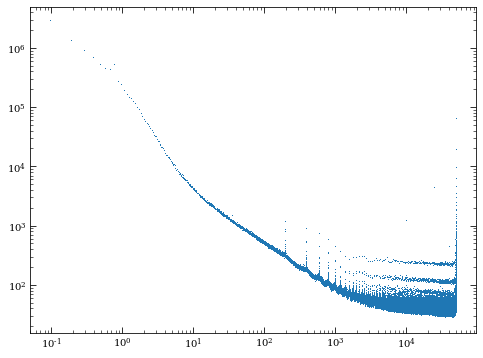

In [47]:
y = np.median(ps_mean, axis=0) 
plt.loglog(freq[1:], y[1:], ls='none', marker=',')
    
# ind = freq>1e4
# print(np.median(lin_mean[:,ind], axis=1))

[5.70479215 5.65130383 6.14014126 7.0674458 ]


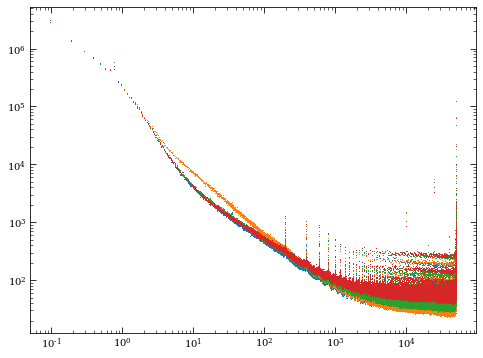

In [48]:
y = ps_mean #np.sqrt(np.mean(pow_spec_arr, axis=0))
for ch in np.arange(nchan):
    plt.loglog(freq[1:], y[ch,1:], ls='none', marker=',')
    
ind = (freq>2e4) & (freq<4.5e4)
print(np.median(lin_mean[:,ind], axis=1))

In [29]:
y = ps_mean #np.sqrt(np.mean(pow_spec_arr, axis=0))
for ch in np.arange(nchan):
    plt.loglog(freq[1:], y[ch,1:], ls='none', marker=',')
    
# ind = freq>1e4
# print(np.median(lin_mean[:,ind], axis=1))

In [27]:
# Residual data 1/f noise spectrum
fs = det._pixel_rate
dt =  1. / fs

ps_data = []
for ch in trange(nchan):
    # Array of pixel values
    sig = data[:,:,ch*chsize:(ch+1)*chsize]
    if np.mod(ch,2)==1: # Flip x-axis for odd channels
        sig = sig[:,:,::-1]
    sig = sig.reshape([sig.shape[0],-1])
    npix = sig.shape[1]
    
    # Power spectrum
    ps = np.abs(np.fft.rfft(sig))**2 / npix
    # Average of all power spectra
    ps_data.append(np.median(ps, axis=0))
    
del ps

ps_data  = np.array(ps_data)
lin_data = np.sqrt(ps_data)

print(freq.shape, ps_data.shape)


(524289,) (4, 524289)


[3.99219467 3.93287799 4.23014358 4.90918934]


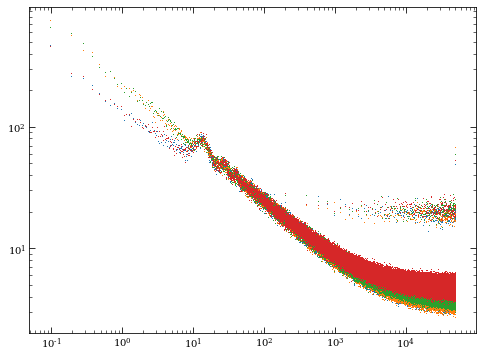

In [28]:
for ch in np.arange(nchan):
    plt.loglog(freq[1:], lin_data[ch,1:], ls='none', marker=',')
    
ind = freq>1e4
print(np.median(lin_data[:,ind], axis=1))

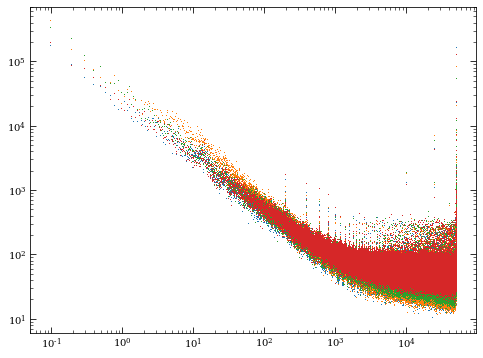

In [23]:
y = ps #np.sqrt(np.mean(pow_spec_arr, axis=0))
for ch in np.arange(nchan):
    plt.loglog(freq[1:], y[ch,1:], ls='none', marker=',')
    
# ind = freq>1e4
# print(np.median(lin_mean[:,ind], axis=1))

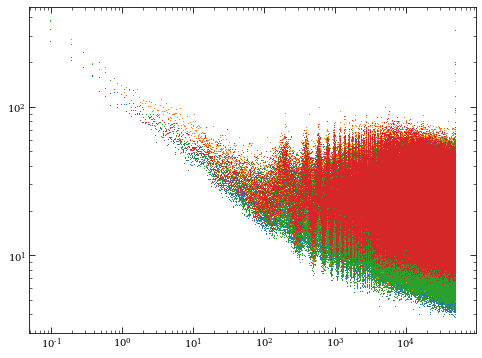

In [32]:
y = np.sqrt(pow_spec_arr[10,:,:])
for ch in np.arange(nchan):
    plt.loglog(freq[1:], y[ch,1:], ls='none', marker=',')
    
# ind = freq>1e4
# print(np.median(lin_mean[:,ind], axis=1))

In [41]:
# Residual data 1/f noise spectrum
fs = det._pixel_rate
dt =  1. / fs

ps_data2 = []
for ch in trange(nchan):
    # Array of pixel values
    sig = data2[:,:,ch*chsize:(ch+1)*chsize]
    if np.mod(ch,2)==1: # Flip x-axis for odd channels
        sig = sig[:,:,::-1]
    sig = sig.reshape([sig.shape[0],-1])
    npix = sig.shape[1]
    
    # Power spectrum
    ps = np.abs(np.fft.rfft(sig))**2 / npix
    # Average of all power spectra
    ps_data2.append(np.median(ps, axis=0))
    
del ps

ps_data2  = np.array(ps_data2)
lin_data2 = np.sqrt(ps_data2)

print(freq.shape, ps_data2.shape)


(524289,) (4, 524289)


[14.23286804 16.77815574 16.47027883 14.82297376]


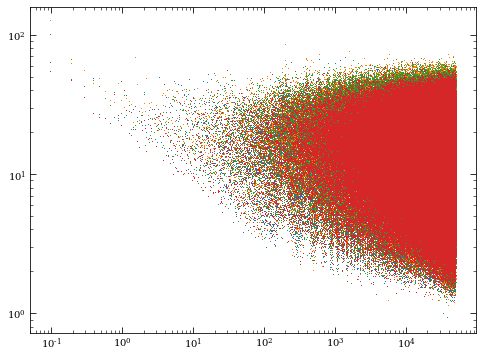

In [42]:
for ch in np.arange(nchan):
    plt.loglog(freq[1:], lin_data2[ch,1:], ls='none', marker=',')
    
ind = freq>1e4
print(np.median(lin_data2[:,ind], axis=1))

In [20]:
ramp_super = np.mean(self.super_dark_ramp.reshape([nz,-1]), axis=1)

In [21]:
ramp = np.mean(data.reshape([nz,-1]), axis=1)

In [81]:
ramp2 = np.median(data2.reshape([nz,-1]), axis=1)

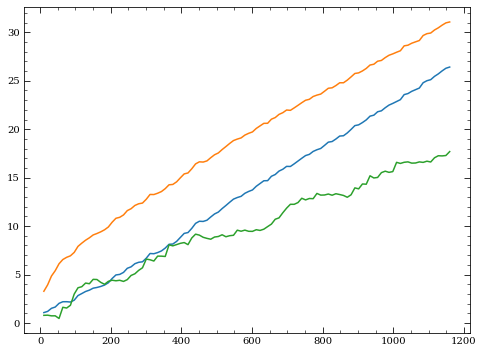

In [22]:
plt.plot(tarr, ramp)
#plt.plot(tarr, ramp2)
plt.plot(tarr, ramp_super)
plt.plot(tarr, data[:,100,100])
#plt.plot(tarr, data2[:,100,100])

In [72]:
cf = jl_poly_fit(tarr, data)
print(np.median(self.super_dark), np.median(cf[1]))

0.022484400984307356 0.018033652029509746


In [46]:
np.median(cf2[1])

0.017327817199174336

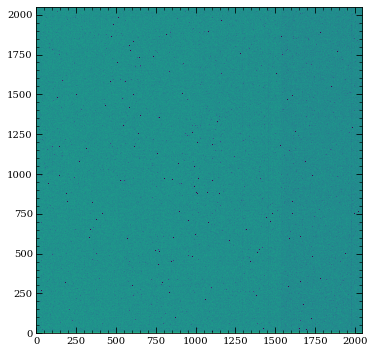

In [42]:
im = self.super_dark - cf[1]
mn = np.median(im)
std = np.std(im)

plt.imshow(im, vmin=mn-3*std, vmax=mn+3*std)

In [34]:
ch_poh = chsize + nroh
ny_poh = ny + nfoh

# Compute the number of time steps per integration, per output
nstep_frame = ch_poh * ny_poh
nstep = nstep_frame * nz
# Pad nsteps to a power of 2, which is much faster
nstep2 = int(2**np.ceil(np.log2(nstep)))

# # Define frequency arrays       
# f1 = np.fft.rfftfreq(nstep2) # Frequencies for nstep elements
# f2 = np.fft.rfftfreq(2*nstep2) # ... for 2*nstep elements
# f3 = np.fft.rfftfreq(2*nz)

# # First element should not be 0
# f1[0] = f1[1]
# f2[0] = f2[1]
# f3[0] = f3[1]


# # Define pinkening filters. F1 and p_filter1 are used to
# # generate ACN. F2 and p_filter2 are used to generate 1/f noise.
# # F2 and p_filter2 are used to generate reference instabilities.
# alpha = -1 # Hard code for 1/f noise until proven otherwise
# p_filter1 = np.sqrt(f1**alpha)
# p_filter2 = np.sqrt(f2**alpha)
# p_filter3 = np.sqrt(f3**alpha)
# p_filter1[0] = 0.
# p_filter2[0] = 0.
# p_filter3[0] = 0.


# Simulated Pink Noise with std=1
%time ch_pink = pink_noise(2*nstep).reshape([nz, ny_poh, ch_poh])[:,0:ny,0:chsize]

CPU times: user 17.6 s, sys: 5.19 s, total: 22.8 s
Wall time: 22.9 s


In [35]:
# Calculate average 1/f noise spectrum
fs = det._pixel_rate
dt =  1. / fs

# Array of pixel values
sig = ch_pink
sig = sig.reshape([sig.shape[0],-1])
npix = sig.shape[1]

# Power spectrum
ps = np.abs(np.fft.rfft(sig))**2 / npix

# Average of all power spectra
ps_sim = np.median(ps, axis=0)
lin_sim = np.sqrt(ps_sim)
freq_sim = np.fft.rfftfreq(npix, d=dt)

del ps, sig, ch_pink

print(freq_sim.shape, ps_sim.shape)

(524289,) (524289,)


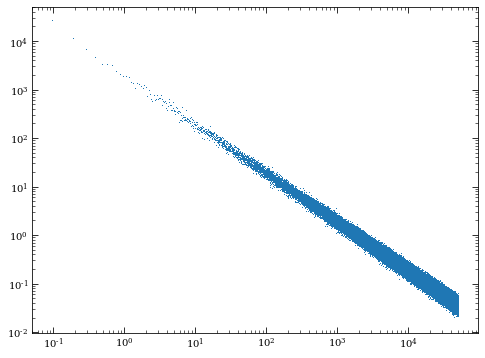

In [36]:
plt.loglog(freq_sim[1:], ps_sim[1:], ls='none', marker=',')

In [44]:
del data, fn_data, fn_data_corr

In [80]:
allfiles = self.allfiles
superbias = self.super_bias

nfiles = len(allfiles)

f = allfiles[10]

kwargs = {
    'nchans': nchan, 'altcol': True, 'in_place': True,    
    'fixcol': False, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
}
kwargs['fixcol'] = False
data2 = get_fits_data(f, bias=superbias, reffix=True, **kwargs)

# Subtract average dark ramp
# data -= self.super_dark_ramp

# Subtract slope fits
# cf2 = jl_poly_fit(tarr, data2)
# data2 -= jl_poly(tarr,cf)

In [17]:
del self._super_dark_ramp
self._super_dark_ramp = None

In [27]:
# Extract 1/f noise from data
fn_data = []
for im in data:
    ch_arr = im.reshape([ny,-1,chsize]).transpose([1,0,2])
    mask = np.abs(im - np.median(im)) > 10*robust.medabsdev(im)
    mask = mask.reshape([ny,-1,chsize]).transpose([1,0,2])
    fnoise = channel_smooth_savgol(ch_arr, mask=mask)
    fnoise = fnoise.transpose([1,0,2]).reshape([ny,nx])
    fn_data.append(fnoise)
fn_data = np.array(fn_data)

# Subtract from data
data -= fn_data

# Split into correlated and uncorrelated components
fn_data_corr = []
for j, im in enumerate(fn_data):
    fn_corr = channel_averaging(im, nchans=nchan,  off_chans=False,
        same_scan_direction=False, mn_func=np.mean)
    # Subtract from fn_data
    fn_data[j] -= fn_corr
    # Only append first channel since the rest are the same data
    fn_data_corr.append(fn_corr[:,0:chsize])
fn_data_corr = np.array(fn_data_corr)


In [28]:
# Correlated 1/f noise spectrum
fs = det._pixel_rate
dt =  1. / fs

# Array of pixel values
sig = fn_data_corr
sig = sig.reshape([sig.shape[0],-1])
npix = sig.shape[1]

# Power spectrum
ps = np.abs(np.fft.rfft(sig))**2 / npix

# Average of all power spectra
ps_corr = np.median(ps, axis=0)
lin_corr = np.sqrt(ps_corr)
# freq_corr = np.fft.rfftfreq(npix, d=dt)

del ps

print(freq_sim.shape, ps_corr.shape)

(524289,) (524289,)


In [29]:
# Uncorrelated 1/f noise spectrum
fs = det._pixel_rate
dt =  1. / fs

ps_uncorr = []

for ch in trange(nchan):
    # Array of pixel values
    sig = fn_data[:,:,ch*chsize:(ch+1)*chsize]
    if np.mod(ch,2)==1: # Flip x-axis for odd channels
        sig = sig[:,:,::-1]
    sig = sig.reshape([sig.shape[0],-1])
    npix = sig.shape[1]
    
    # Power spectrum
    ps = np.abs(np.fft.rfft(sig))**2 / npix
    # Average of all power spectra
    ps_uncorr.append(np.median(ps, axis=0))
    
del ps

ps_uncorr  = np.array(ps_uncorr)
lin_uncorr = np.sqrt(ps_uncorr)

print(freq_sim.shape, ps_uncorr.shape)


(524289,) (4, 524289)


In [37]:
# Residual data 1/f noise spectrum
fs = det._pixel_rate
dt =  1. / fs

ps_data = []
for ch in trange(nchan):
    # Array of pixel values
    sig = data[:,:,ch*chsize:(ch+1)*chsize]
    if np.mod(ch,2)==1: # Flip x-axis for odd channels
        sig = sig[:,:,::-1]
    sig = sig.reshape([sig.shape[0],-1])
    npix = sig.shape[1]
    
    # Power spectrum
    ps = np.abs(np.fft.rfft(sig))**2 / npix
    # Average of all power spectra
    ps_data.append(np.median(ps, axis=0))
    
del ps

ps_data  = np.array(ps_data)
lin_data = np.sqrt(ps_data)

print(freq_sim.shape, ps_data.shape)


(524289,) (4, 524289)


[26.03747274 30.82267074 30.10276519 27.10209756]


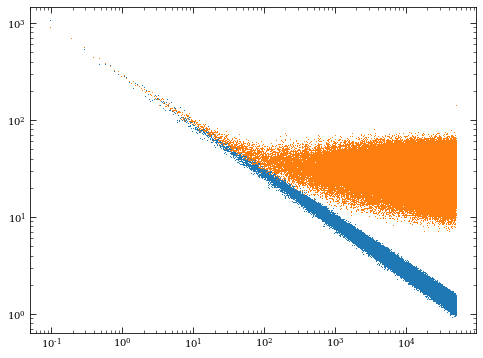

In [38]:
plt.loglog(freq_sim[1:], 6.5*lin_sim[1:], ls='none', marker=',')
plt.loglog(freq_sim[1:], np.median(lin_data[:,1:],axis=0), ls='none', marker=',')
# for ch in np.arange(nchan):
#     plt.loglog(freq_sim[1:], lin_data[ch,1:], ls='none', marker=',')
    
ind = freq_sim>1e4
print(np.median(lin_data[:,ind], axis=1))

In [31]:
plt.loglog(freq_sim[1:], 6.5*lin_sim[1:], ls='none', marker=',')
plt.loglog(freq_sim[1:], np.median(lin_data[:,1:],axis=0), ls='none', marker=',')
# for ch in np.arange(nchan):
#     plt.loglog(freq_sim[1:], lin_data[ch,1:], ls='none', marker=',')
    
ind = freq_sim>1e4
print(np.median(lin_data[:,ind], axis=1))

[4.80434817 4.81169389 4.81031294 4.80579026]


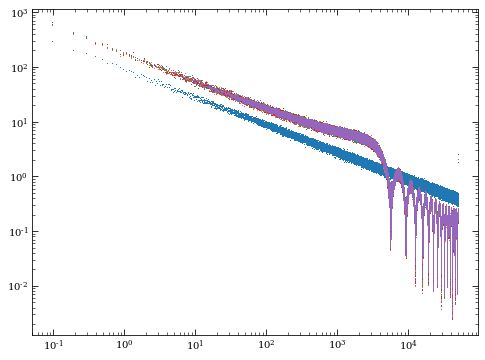

In [32]:
plt.loglog(freq_sim[1:], 2*lin_sim[1:], ls='none', marker=',')
for ch in np.arange(nchan):
    plt.loglog(freq_sim[1:], lin_uncorr[ch,1:], ls='none', marker=',')

In [33]:
plt.loglog(freq_sim[1:], 3*lin_sim[1:], ls='none', marker=',')
plt.loglog(freq_sim[1:], lin_corr[1:], ls='none', marker=',')

In [ ]:
fs = det._pixel_rate
dt =  1. / fs

ps1_arr = []
lin1_arr = []

for ch in trange(nchan):
    # Array of pixel values
    sig = data[:20,:,ch*chsize:(ch+1)*chsize]
    if np.mod(ch,2)==1: # Flip x-axis for odd channels
        sig = sig[:,:,::-1]
    sig = sig.reshape([sig.shape[0],-1])
    npix = sig.shape[1]
#     sig = np.random.randn(100000,108)*5.7
    
    # Power spectrum
    ps = np.abs(np.fft.rfft(sig))**2 / npix
    # Average of all power spectra
    ps_mean = np.median(ps, axis=0)
    ps1_arr.append(ps_mean)
    
del ps

ps1_arr  = np.array(ps1_arr)
lin1_arr = np.sqrt(ps1_arr)
freq1 = np.fft.rfftfreq(npix, d=dt)

print(sig.shape, freq1.shape, ps1_arr.shape)

In [14]:
from pynrc.nrc_utils import pad_or_cut_to_size

xsize = det.chsize + det._line_overhead
ysize = det.ypix + det._extra_lines

data_new = np.zeros([nz,ysize,nchan*xsize])
tvals = np.arange(data_new.size / nchan)

for ch in trange(nchan):
    # Build new data per channel
    data_ch = []
    for im in data[:,:,ch*chsize:(ch+1)*chsize]:
        im_new = pad_or_cut_to_size(im, (ysize,xsize), fill_val=np.nan)
        if np.mod(ch,2)==1:
            im_new = im_new[:,::-1]
        data_ch.append(im_new)
    data_ch = np.array(data_ch)

    # Interpolate NaNs
    sh = data_ch.shape
    data_ch = data_ch.ravel()
    ind_nan = np.isnan(data_ch)
    data_ch[ind_nan] = np.interp(tvals[ind_nan], tvals[~ind_nan], data_ch[~ind_nan])
    data_ch = data_ch.reshape(sh)
    
    # Save to data_new array
    data_new[:,:,ch*xsize:(ch+1)*xsize] = data_ch
    
del tvals, ind_nan, data

In [15]:
data = data_new
chsize = xsize

In [50]:
fs = det._pixel_rate
dt =  1. / fs

ps1_arr = []
lin1_arr = []

for ch in trange(nchan):
    # Array of pixel values
    sig = data[:,:,ch*chsize:(ch+1)*chsize]
    if np.mod(ch,2)==1: # Flip x-axis for odd channels
        sig = sig[:,:,::-1]
    sig = sig.ravel()
    npix = len(sig)
#     sig = np.random.randn(100000,108)*5.7
    
    # Power spectrum
    ps = np.abs(np.fft.rfft(sig))**2 / npix
    ps1_arr.append(ps)

ps1_arr  = np.array(ps1_arr)
lin1_arr = np.sqrt(ps1_arr)
freq1 = np.fft.rfftfreq(npix, d=dt)

print(sig.shape, freq1.shape, ps1_arr.shape)


(115957008,) (57978505,) (4, 57978505)


In [21]:
# Welch's Method
from scipy.signal import welch

fs = det._pixel_rate
dt =  1. / fs

ps2_arr = []
lin2_arr = []

for ch in trange(nchan):
    # Array of pixel values
    sig = data[:,:,ch*chsize:(ch+1)*chsize]
    if np.mod(ch,2)==1: # Flip x-axis for odd channels
        sig = sig[:,:,::-1]
    sig = sig.ravel()

    # Power spectrum
    freq2, ps = welch(sig, fs, detrend=False, average='median', 
                      window='hann', nperseg=2**12)
    ps *= fs / 2
    ps2_arr.append(ps)
    
ps2_arr  = np.array(ps2_arr)
lin2_arr = np.sqrt(ps2_arr)

print(sig.shape, freq2.shape, ps2_arr.shape)


(115957008,) (2049,) (4, 2049)


In [22]:
plt.loglog(freq2[1:], ps2_arr[0,1:])


(20, 1073676) (536839,) (4, 536839)


In [42]:
# Welch's Method
from scipy.signal import welch

ps2_arr = []
lin2_arr = []

for ch in trange(nchan):
    # Array of pixel values
    sig = data[:20,:,ch*chsize:(ch+1)*chsize]
    if np.mod(ch,2)==1: # Flip x-axis for odd channels
        sig = sig[:,:,::-1]
    sig = sig.reshape([sig.shape[0],-1])

    # Power spectrum
    freq2, ps = welch(sig, fs, detrend=False, average='median', 
                      window='hann', nperseg=2**16)
    ps *= fs / 2
    ps_mean = np.median(ps, axis=0)
    ps2_arr.append(ps_mean)
    
ps2_arr  = np.array(ps2_arr)
lin2_arr = np.sqrt(ps2_arr)

print(sig.shape, freq2.shape, ps2_arr.shape)


(20, 1073676) (32769,) (4, 32769)


In [44]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

carr = ['C0', 'C1', 'C2', 'C3']

ax = axes[0]
for ch in np.arange(nchan):
    x = freq1[1:]
    y = ps1_arr[ch, 1:]
    ax.loglog(x, y, color=carr[ch], alpha=0.25)

    x = freq2[1:]
    y = ps2_arr[ch, 1:]
    ax.loglog(x, y, color=carr[ch], ls='--')

ax = axes[1]
for ch in np.arange(nchan):
#     x = freq1[1:]
#     y1 = lin1_arr[ch,1:]
#     ax.loglog(x, y1, color=carr[ch])
    
    x = freq2[1:]
    y2 = lin2_arr[ch,1:]
    ax.loglog(x, y2, color=carr[ch], ls='--')
    
    ind = x>1e4
    print(robust.mean(y2[ind]))

def tick_function(X):
    V = 1000. / X
    return ["%.3f" % z for z in V]

    
for ax in axes:
    ylim = ax.get_ylim()
    ax.plot(2*[1. / det.time_frame], ylim, color='grey', ls='--')
    ltime = (det.chsize + det._line_overhead) / det._pixel_rate
    ax.plot(2*[1. / ltime], ylim, color='grey', ls='--')
    ax.plot(2*[2. / ltime], ylim, color='grey', ls='--')
    wsize = 16 / det._pixel_rate
    ax.plot(2*[1. / wsize], ylim, color='grey', ls='--')    
    ax.set_ylim(ylim)

    
for ax in axes:
    ax.set_xlim([1e-1, 1e5])
    xloc = np.array(ax.get_xticks())
    xlim = ax.get_xlim()
    xind = (xloc>=xlim[0]) & (xloc<=xlim[1])
    new_tick_locations = xloc[xind]

    ax2 = ax.twiny()
    ax2.set_xlim(1/np.array(xlim))
    ax2.set_xscale('log')
#     ax2.set_xticks(new_tick_locations)
#     ax2.set_xticklabels(tick_function(new_tick_locations))
    
    ax.set_xlabel('Frequency (Hz)')
    ax2.set_xlabel('Time (sec)')
    
    ax.set_xlim(xlim)
    
fig.tight_layout()

6.134913006490111
7.492081829476156
7.021665699986549
10.080592038527426


99999.99999999999

In [33]:
np.log10(freq1[1:])

array([-1.0120607 , -0.71103071, -0.53493945, ...,  4.69896831,
        4.69896916,  4.69897   ])

In [35]:
from pynrc.maths.image_manip import binned_statistic

In [60]:
xlog = np.log10(freq2[1:])
yval = ps2_arr[0, 1:]

binsize = 0.01
bins = np.arange(xlog.min(), xlog.max() + binsize, binsize)
ig, vg, cv = hist_indices(yval, bins=bins, return_more=True)

res = binned_statistic(xlog, yval, func=np.median, bins=bins)

In [61]:
ind = ~np.isnan(res)
plt.loglog(10**cv[ind], res[ind])

In [709]:
ch=0
sig = data[10,4:-4,ch*chsize+4:(ch+1)*chsize-4].flatten()
npix = len(sig)

fs = det._pixel_rate
dt =  1. / fs

tvals = np.arange(npix)*dt+dt

freq1 = np.fft.rfftfreq(npix, d=dt)+fs

In [710]:
from scipy.signal import lombscargle

In [13]:
tvals = det.pix_timing_map()

In [53]:
tvals_ch1 = tvals[0,:,0:512].flatten()
sig = data[0,:,0:512].flatten()

freq = np.fft.rfftfreq(int(len(sig)/2), d=10e-6)[1:]

# Log spacing
nbins = 500
log_freq = np.log10(freq)
v0 = log_freq.min()
v1 = log_freq.max()
binsize = (v1 - v0) / nbins
freq_req_log = np.arange(v0, v1 + binsize, binsize)
freq_req = 10**freq_req_log

# plt.plot(tvals_ch1,sig)

In [54]:
print(len(freq_req))
%time pgram = lombscargle(tvals_ch1, sig, freq_req)

501
CPU times: user 6.12 s, sys: 26.5 ms, total: 6.14 s
Wall time: 6.13 s


In [55]:
plt.loglog(freq_req, pgram, marker='.')

In [691]:
ntime = len(tarr)

dt = tarr[1] - tarr[0]
fs = 1. / dt
freq1 = np.fft.rfftfreq(ntime, d=dt)

ps1_arr = []
ps2_arr = []
lin1_arr = []
lin2_arr = []

for ch in trange(nchan):
    # Array of pixel values
    sig = data[:,4:-4,ch*chsize+4:(ch+1)*chsize-4].reshape([nz,-1])
    sig = sig.transpose([1,0])
#     sig = np.random.randn(100000,108)*5.7
    
    # Power spectrum
    ps = np.abs(np.fft.rfft(sig))**2 / ntime
    # Average of all power spectra
    ps_mean = np.median(ps, axis=0)
    ps1_arr.append(ps_mean)
    
    # Welch's Method
    freq2, ps = welch(sig, fs, nperseg=2048, detrend=False, average='median')
    ps *= fs / 2
    ps_mean = np.median(ps, axis=0)
    ps2_arr.append(ps_mean)

    
ps1_arr  = np.array(ps1_arr)
ps2_arr  = np.array(ps2_arr)

lin1_arr = np.sqrt(ps1_arr)
lin2_arr = np.sqrt(ps2_arr)


4.914341870715233 4.917977548556133
4.850661945917401 4.986628999362943
5.164005927979491 5.105169548988483
5.7562919156983785 5.726702889674392


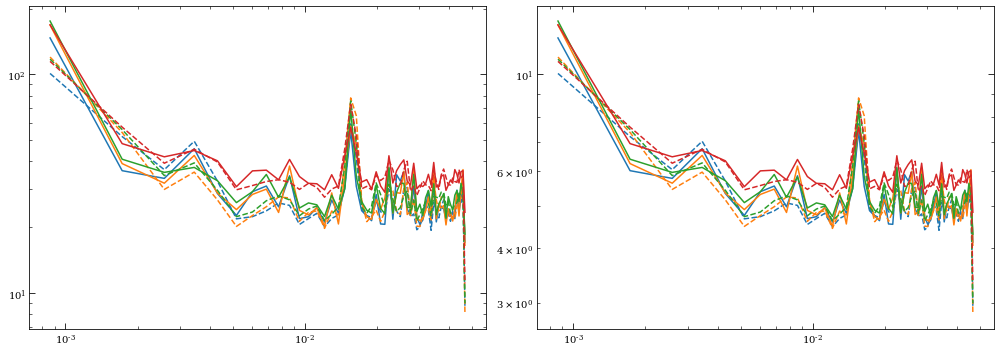

In [694]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

carr = ['C0', 'C1', 'C2', 'C3']

ax = axes[0]
for ch in np.arange(nchan):
    x = freq1[1:]
    y = ps1_arr[ch, 1:]
    ax.loglog(x, y, color=carr[ch])

    x = freq2[1:]
    y = ps2_arr[ch, 1:]
    ax.loglog(x, y, color=carr[ch], ls='--')

ax = axes[1]
for ch in np.arange(nchan):
    x = freq1[1:]
    y1 = lin1_arr[ch,1:]
    ax.loglog(x, y1, color=carr[ch])
    
    x = freq2[1:]
    y2 = lin2_arr[ch,1:]
    ax.loglog(x, y2, color=carr[ch], ls='--')
    
    ind = x>3e-2
    print(robust.mean(y1[ind]), robust.mean(y2[ind]))

# for ax in axes:
#     ax.set_xlim([1e-4,1e-1])
    
fig.tight_layout()

In [692]:
y1

array([ 3.70675668, 12.98335919,  6.94528724,  6.4793177 ,  6.69855254,
        6.3435842 ,  5.53683711,  6.01693171,  6.03925216,  5.73993262,
        6.38972316,  5.83955983,  5.635357  ,  5.62224088,  5.44516045,
        5.89549416,  5.48825228,  6.51827772,  7.56727058,  6.60244955,
        5.67256143,  5.74511703,  5.46566596,  5.98828149,  5.55784948,
        5.37600218,  6.5154488 ,  5.64400492,  6.02359364,  6.22052029,
        6.37507333,  5.69871126,  5.58987312,  6.26317493,  5.47530087,
        5.58084085,  5.54198717,  5.62581685,  5.90936147,  5.58578283,
        6.28936887,  5.53022049,  5.55296659,  5.84958026,  5.88867237,
        5.42972719,  5.58450084,  5.73586849,  5.6416812 ,  6.05747623,
        5.90704985,  5.64503698,  5.99170314,  6.02190474,  4.83796242])

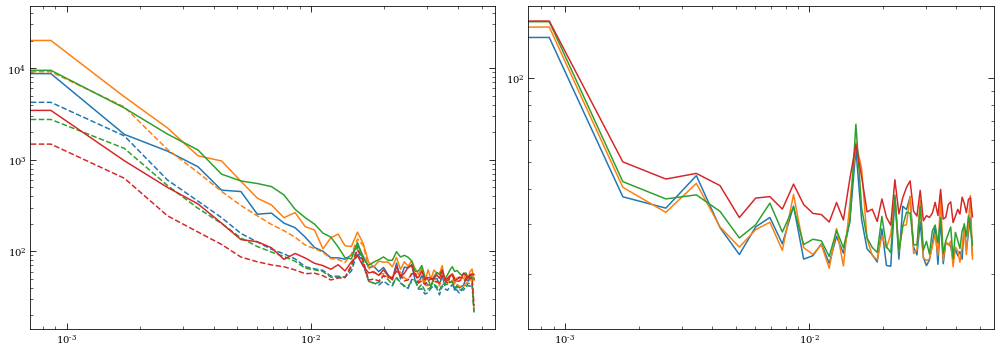

In [674]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

x = freq
carr = ['C0', 'C1', 'C2', 'C3']

for ch in np.arange(nchan):
    y = ps1_arr[ch]
    axes[0].loglog(x, y, color=carr[ch])
    y = ps2_arr[ch]
    axes[0].loglog(x, y, color=carr[ch], ls='--')

for ch in np.arange(nchan):
    y = _ps_arr[ch]
    axes[1].loglog(x, y)

fig.tight_layout()

6.261633647510323
6.695784163715412
6.43544246391399
6.982209469809884


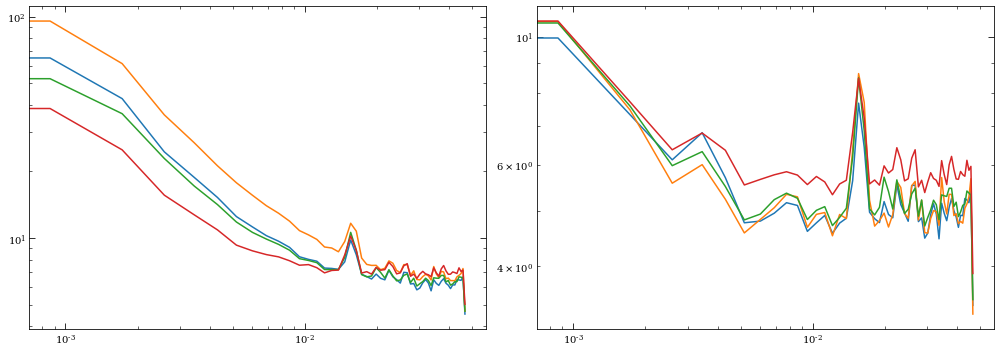

In [667]:
fig, axes = plt.subplots(1,2,figsize=(14,5))

carr = ['C0', 'C1', 'C2', 'C3']

x = freq

ax = axes[0]
for ch in np.arange(nchan):
    y = lin1_arr[ch]
    ax.loglog(x, y, color=carr[ch])
    ind = x>3e-2
    print(np.median(y[ind]))

ax = axes[1]
for ch in np.arange(nchan):
    y = _lin1_arr[ch]
    ax.loglog(x, y, color=carr[ch])

fig.tight_layout()

In [501]:
# Welch's Method
from scipy.signal import welch

%time f, psd1 = welch(sig, fs=fs)#, window='flattop', detrend=False, nperseg=1024, scaling='spectrum')
ps_mean1 = 0.8*np.mean(np.sqrt(psd1*fs), axis=0)

# f, psd = welch(sig,
#                fs=fs,  # sample rate
#                window='hann',      # apply a Hanning window before taking the DFT
#                nperseg=256,        # compute periodograms of 256-long segments of x
#                detrend='constant') # detrend x by subtracting the mean

f = np.fft.rfftfreq(tarr.size, d=dt)
%time ps = np.abs(np.fft.rfft(sig))**2
ps_mean2 = np.sqrt(np.mean(ps, axis=0) / len(tarr))


CPU times: user 770 ms, sys: 130 ms, total: 899 ms
Wall time: 899 ms
CPU times: user 426 ms, sys: 64.9 ms, total: 490 ms
Wall time: 491 ms


In [502]:
ind = f>3e-2
print(np.median(ps_mean1[ind]), np.median(ps_mean2[ind]))

5.856029530916452 6.300673880023961


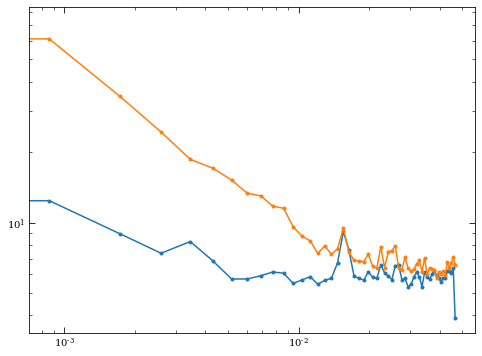

In [503]:
plt.loglog(f, ps_mean1, marker='.')
plt.loglog(f, ps_mean2, marker='.')

In [68]:
sig = data.reshape([nz,-1]).transpose([1,0])
dt = tarr[1] - tarr[0]

# plt.loglog(f, np.abs(psd)**2)

CPU times: user 7.51 s, sys: 2.3 s, total: 9.81 s
Wall time: 9.86 s


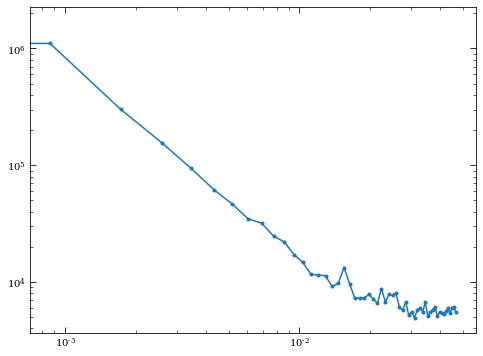

In [70]:
plt.loglog(f, psd_mean, marker='.')

In [38]:
f

array([0.        , 0.00086239, 0.00172478, 0.00258716, 0.00344955,
       0.00431194, 0.00517433, 0.00603671, 0.0068991 , 0.00776149,
       0.00862388, 0.00948627, 0.01034865, 0.01121104, 0.01207343,
       0.01293582, 0.0137982 , 0.01466059, 0.01552298, 0.01638537,
       0.01724776, 0.01811014, 0.01897253, 0.01983492, 0.02069731,
       0.02155969, 0.02242208, 0.02328447, 0.02414686, 0.02500925,
       0.02587163, 0.02673402, 0.02759641, 0.0284588 , 0.02932118,
       0.03018357, 0.03104596, 0.03190835, 0.03277074, 0.03363312,
       0.03449551, 0.0353579 , 0.03622029, 0.03708267, 0.03794506,
       0.03880745, 0.03966984, 0.04053223, 0.04139461, 0.042257  ,
       0.04311939, 0.04398178, 0.04484416, 0.04570655, 0.04656894])

In [398]:
std = 5
nsamp = 100
npix = 100000

sig = np.random.randn(npix,nsamp)*std
ps = np.abs(np.fft.rfft(sig))**2

print(ps.shape)

ps_mean = np.mean(ps, axis=0)

(100000, 51)


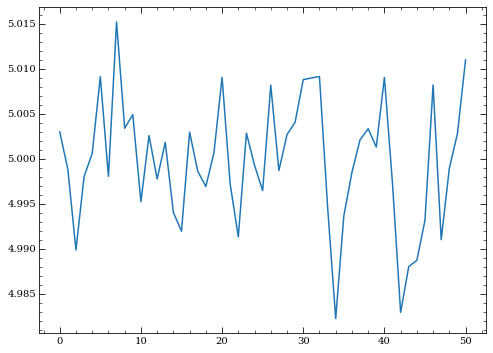

In [402]:
plt.plot(np.sqrt(ps_mean / nsamp))

In [399]:
np.sqrt(np.mean(ps) / nsamp) 

4.999753428292934

In [243]:
std / np.sqrt(np.mean(psd1))

9.299308930320352

In [357]:
fs = 10e3
N = 108
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs

std = np.sqrt(noise_power)
sig = np.random.normal(scale=std, size=(10, len(time)))

f, Pxx_den = welch(sig, fs, window='hann', nperseg=128)
Pxx_mean = np.mean(Pxx_den, axis=0)

print(f.shape, Pxx_den.shape)

(55,) (10, 55)


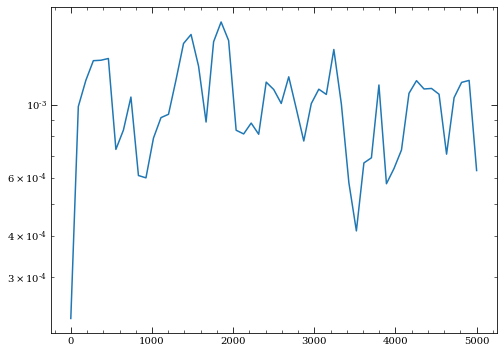

In [358]:
plt.semilogy(f, Pxx_mean)
# plt.ylim([0.5e-3, 1])
# plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')


In [359]:
print(std)
print(sig.std())

2.23606797749979
2.1840643366695915


In [360]:
print(np.sqrt(robust.mean(Pxx_den) * fs / 2))

1.9788459468606203


In [6]:
# basedir = '/Volumes/NIRData/NIRCam/Char_Darks/CV3/FITS/'
basedir = '/Users/jarron/NIRCam/Data/CV3_Darks/'

scaid = 485
indir = os.path.join(basedir, str(scaid)) + '/'

# Get file names within directory
allfits = [file for file in os.listdir(indir) if file.endswith('.fits')]
allfits = np.sort(allfits)

nfiles = len(allfits)

In [7]:
all_files = [indir + f for f in allfits]

In [8]:
# Get header information and create a NIRCam detector timing instance
hdr = fits.getheader(indir+allfits[0])
det = create_detops(hdr)

nchan = det.nout
nx = det.xpix
ny = det.ypix
nz = det.multiaccum.ngroup
chsize = det.chsize

# Time array
tarr = np.arange(1, nz+1) * det.time_group

[     pynrc:INFO] Initializing SCA 485/A5


In [ ]:
det.pix_timing_map

In [9]:
outdir = '/Users/jarron/NIRCam/dark_analysis/CV3/'
# outdir = os.path.join(outdir, str(scaid)) + '/'

# Initial Super Bias Image

In [10]:
outname = f'{outdir}SUPER_BIAS/SUPER_BIAS_INIT_{scaid}.FITS'
file_exists = os.path.isfile(outname)

In [22]:
'nchan' in kwargs

False

In [11]:
kwargs = {
    'nchans': nchan, 'altcol': True, 'in_place': True,    
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
}

if file_exists:
    super_bias, _super_bias = get_fits_data(outname)
else:
    
    super_bias, _super_bias = gen_super_bias(all_files, deg=1, nsplit=2, return_std=True, **kwargs)
    # Save superbias frame to directory
    hdu = fits.PrimaryHDU(np.array([super_bias, _super_bias]))
    hdu.writeto(outname, overwrite=True)

# Super Dark Ramp

In [12]:
# Create or read super dark ramp
kwargs = {
    'nchans': nchan, 'altcol': True, 'in_place': True,    
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
}

outname = f'{outdir}SUPER_DARK/SUPER_DARK_RAMP_{scaid}.FITS'
file_exists = os.path.isfile(outname)

if file_exists:
    super_dark_ramp = get_fits_data(outname)
    
    # Grab Super Bias
    outname = f'{outdir}SUPER_BIAS/SUPER_BIAS_{scaid}.FITS'
    super_bias = get_fits_data(outname)
    
    # Generate pixel masks dictionary
    outname = f'{outdir}SUPER_DARK/PIXEL_MASKS_{scaid}.FITS.gz'
    masks_dict = {}
    hdul = fits.open(outname)
    for hdu in hdul:
        key = hdu.name.lower()
        masks_dict[key] = hdu.data.astype('bool')
    hdul.close()
else:
    res = gen_super_dark(all_files, super_bias=super_bias, **kwargs)
    super_dark_ramp, bias_off, masks_dict = res

    # Add residual bias offset
    super_bias += bias_off
    
    # Save updated superbias frame to directory
    outname = f'{outdir}SUPER_BIAS/SUPER_BIAS_{scaid}.FITS'
    hdu = fits.PrimaryHDU(super_bias)
    hdu.writeto(outname, overwrite=True)
    
    # Save super dark ramp
    outname = f'{outdir}SUPER_DARK/SUPER_DARK_RAMP_{scaid}.FITS'
    hdu = fits.PrimaryHDU(super_dark_ramp.astype(np.float32))
#     hdu = fits.PrimaryHDU(super_dark_ramp)
    hdu.writeto(outname, overwrite=True)
    
    # Save mask dictionary to a compressed FITS file
    outname = f'{outdir}SUPER_DARK/PIXEL_MASKS_{scaid}.FITS.gz'
    hdul = fits.HDUList()

    for k in masks_dict.keys():
        data = masks_dict[k].astype('uint8')
        hdu = fits.ImageHDU(data, name=k)
        hdul.append(hdu)

    output = gzip.open(outname, 'wb')
    hdul.writeto(output, overwrite=True) 
    output.close()

# Column Variations

In [13]:
# Create a series of column offset models 
# These are likely FETS in the ASIC preamp or ADC 
# causing entire columns within a ramp to jump around
kwargs = {
    'nchans': nchan, 'altcol': True, 'in_place': True,    
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
}

outname = f'{outdir}SUPER_DARK/SUPER_DARK_COLVAR_{scaid}.FITS'
file_exists = os.path.isfile(outname)

if file_exists:
    ramp_column_varations, header = get_fits_data(outname, return_header=True)
    prob_bad = header['PROB_VAR']
else:
    # Generate a compilation of column variations
    res = gen_col_variations(all_files, super_bias=super_bias, 
                             super_dark_ramp=super_dark_ramp, **kwargs)
    ramp_column_varations, prob_bad = res
    
    # Save column ramp variations
    hdu = fits.PrimaryHDU(ramp_column_varations)
    hdu.header['PROB_VAR'] = prob_bad
    hdu.writeto(outname, overwrite=True)

## Ref Pixels

In [14]:
kwargs = {
    'nchans': nchan, 'altcol': True, 'in_place': True,    
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False    
}

outname = f'{outdir}SUPER_BIAS/BIAS_BEHAVIOR_{scaid}.JSON'
file_exists = os.path.isfile(outname)

if file_exists:
    # Load from JSON file
    with open(outname, 'r') as fp:
        ref_dict = json.load(fp)

    # Convert lists to np.array
    for k in ref_dict.keys():
        if isinstance(ref_dict[k], (list)):
            ref_dict[k] = np.array(ref_dict[k])
else:
    ref_dict = gen_ref_dict(all_files, super_bias, verbose=True, **kwargs)
    
    # Save to JSON file
    # Make a deepcopy of dict to convert np.array to lists
    dtemp = deepcopy(ref_dict)
    for k in dtemp.keys():
        if isinstance(dtemp[k], (np.ndarray)):
            dtemp[k] = dtemp[k].tolist()

    with open(outname, 'w') as fp:
        json.dump(dtemp, fp, sort_keys=False, indent=4)

In [14]:
# Create synthetic data
data = gen_ramp_biases(ref_dict, data_shape=(nz,ny,nx))
data += super_bias
data += super_dark_ramp

col_noise = gen_col_noise(ramp_column_varations, prob_bad)
data += col_noise


# Super Dark Slope

In [14]:
# Get dark slope image
_, super_dark = jl_poly_fit(tarr, super_dark_ramp)

# Average slope in each channel
ramp_avg_ch = []
for ch in range(nchan):
    ramp_ch = super_dark_ramp[:,:,ch*chsize:(ch+1)*chsize]
    avg = np.median(ramp_ch.reshape([nz,-1]), axis=1)
    ramp_avg_ch.append(avg)
ramp_avg_ch = np.array(ramp_avg_ch)

# Average ramp for all pixels
ramp_avg_all = np.median(super_dark_ramp.reshape([nz,-1]), axis=1)

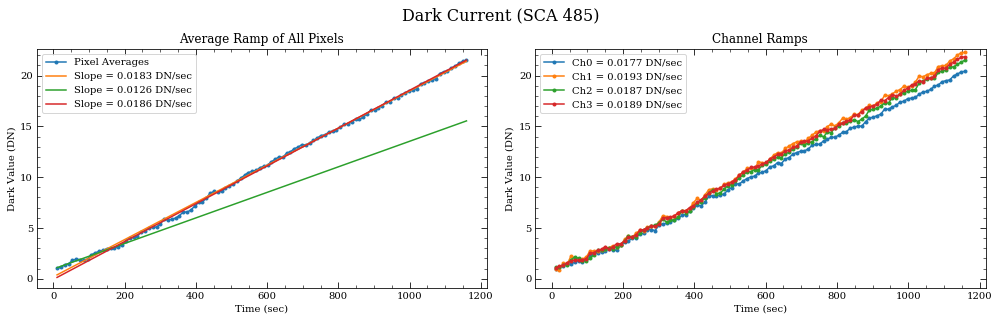

In [19]:
fig, axes = plt.subplots(1,2, figsize=(14,4.5))
axes = axes.flatten()

# Plot average of all pixel
ax = axes[0]
ax.set_title('Average Ramp of All Pixels')
y = ramp_avg_all
ax.plot(tarr, y, marker='.', label='Pixel Averages')

for ind in [tarr>0, tarr<200, tarr>200]:
    cf = jl_poly_fit(tarr[ind], y[ind], deg=1)
    ax.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.4f} DN/sec'.format(cf[1]))

# Plot each channel separately
ax = axes[1]
ax.set_title('Channel Ramps')
for i in range(nchan):
    y = ramp_avg_ch[i]
    cf = jl_poly_fit(tarr[ind], y[ind], deg=1)
    label = 'Ch{} = {:.4f} DN/sec'.format(i, cf[1])
    ax.plot(tarr, y, marker='.', label=label)
    
for ax in axes:
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Dark Value (DN)')
    ax.set_ylim(axes[0].get_ylim())
    ax.legend()

    
fig.suptitle(f'Dark Current (SCA {scaid})', fontsize=16)
    
fig.tight_layout()
fig.subplots_adjust(top=0.85)

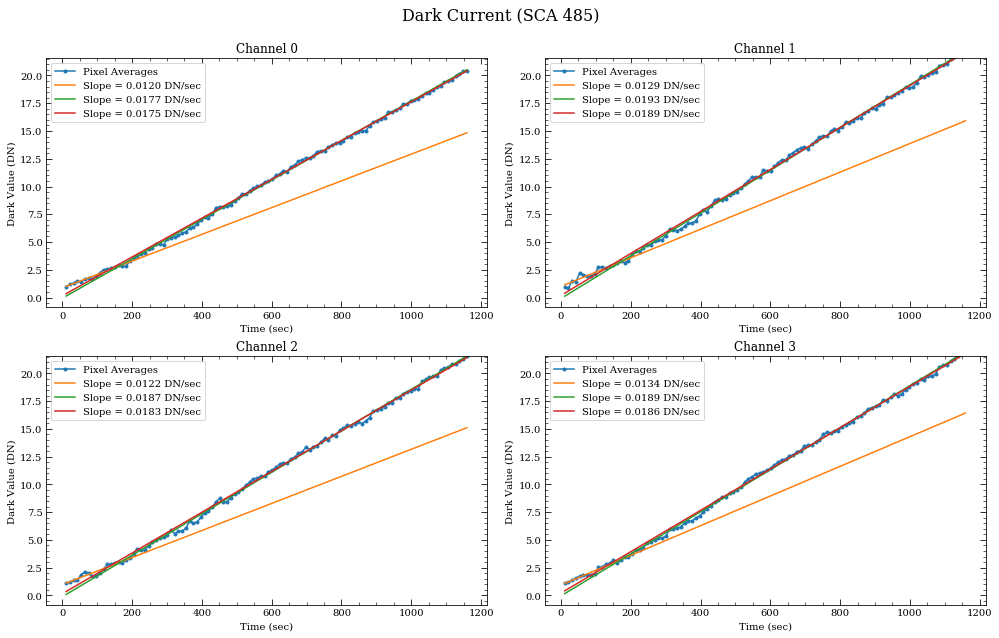

In [21]:
fig, axes = plt.subplots(2,2, figsize=(14,9))
axes = axes.flatten()
    
# Plot Individual Channels
for i in range(nchan):
    ax = axes[i]
    y = ramp_avg_ch[i]
    ax.plot(tarr, y, marker='.', label='Pixel Averages')
    
    for ind in [tarr<200, tarr>200, tarr>0]:
        cf = jl_poly_fit(tarr[ind], y[ind], deg=1)
        ax.plot(tarr, jl_poly(tarr,cf), label='Slope = {:.4f} DN/sec'.format(cf[1]))

    ax.set_title(f'Channel {i}')

for ax in axes:
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Dark Value (DN)')
    ylim1 = np.min()
    ax.legend()

for ax in axes:
    ax.set_ylim([ylim1,ylim2])

    
fig.suptitle(f'Dark Current (SCA {scaid})', fontsize=16)
    
fig.tight_layout()
fig.subplots_adjust(top=0.9)

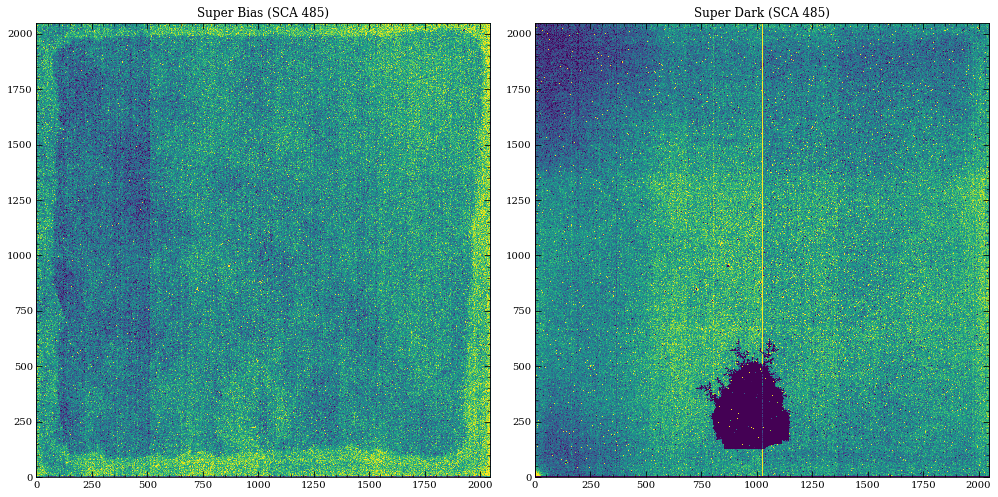

In [17]:
fig, axes = plt.subplots(1,2,figsize=(14,8))

titles = ['Super Bias (SCA {})'.format(scaid), 'Super Dark (SCA {})'.format(scaid)]
for i, im in enumerate([super_bias, super_dark]):

    mn = np.median(im)
    std = robust.medabsdev(im)

    vmin = mn - 3*std
    vmax = mn + 3*std
    ax = axes[i]
    ax.imshow(im, vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])
    
fig.tight_layout()

In [16]:
mask_act = np.zeros([ny,nx]).astype('bool')
mask_act[4:-4,4:-4] = True
mask_ref = ~mask_act

bias_off = np.zeros_like(super_bias)

ramp_avg = super_dark_ramp
mask_neg = ((ramp_avg[0] < 0) & mask_act) | (ramp_avg[0] > 1000) | (ramp_avg[-1] > 10000)
mask_neg = (ramp_avg[0] > 60000) | (ramp_avg[-1] > 50000)

In [65]:
mask_neg = ((super_bias < -1000) & mask_act) & (ramp_avg[-1] > 20000)

In [66]:
len(mask_neg[mask_neg]) 

55

In [67]:
yvals_fit = ramp_avg[:,mask_neg]
dy = ramp_derivative(yvals_fit[0:15], fit0=False, deg=2, ifit=[0,10])
yfit = np.cumsum(dy, axis=0)


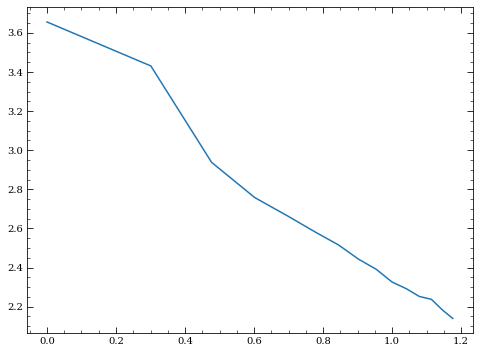

In [68]:
# plt.plot(tarr, yvals_fit[:,0])
x = np.arange(len(dy[:,0])) + 1

xlog = np.log10(x)
ylog = np.log10(dy[:,0])

plt.plot(xlog, ylog)

(0, 80000)

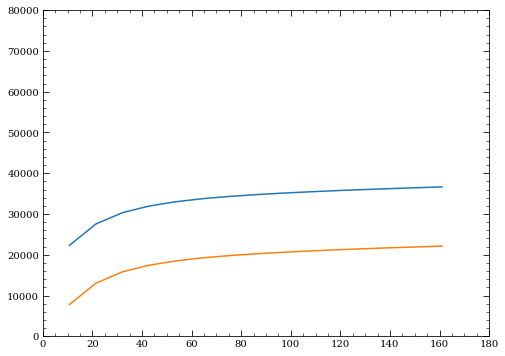

In [71]:
i=10
plt.plot(tarr[0:15], yvals_fit[0:15,i])
plt.plot(tarr[0:15], yfit[:,i])

plt.xlim([0,180])
plt.ylim([0,80000])

In [50]:
plt.plot(tarr, ramp_avg[:,mask_neg2][:,0])

# IPC

In [19]:
# Get IPC & PPC values
# Subtract a blurred dark image to remove local variations
imdark = super_dark.copy()
imdark -= ndimage.median_filter(imdark, 7)

In [31]:
k_ipc, k_ppc = get_ipc_kernel(imdark, tarr.max(), bg_remove=False, calc_ppc=True)

print('IPC = {:.2f}%'.format(k_ipc[0,1]*100))
print('PPC = {:.2f}%'.format(k_ppc[1,2]*100))

IPC = 0.60%
PPC = 0.12%


In [41]:
# Flux-dependent values
vals1 = np.arange(2000,23000,1000)
vals2 = vals1+1000

vals = []
alpha_arr = []
ppc_arr = []
for v1 in vals1:
    res = get_ipc_kernel(imdark, tarr.max(), boxsize=5, bg_remove=False, hotcut=[v1,v1+1000], calc_ppc=True)
    
    if res is not None:
        k1, k2 = res
        vals.append(v1+500)
        alpha_arr.append(k1[0,1])
        ppc_arr.append(k2[1,2])
        
vals = np.array(vals)
alpha_arr = np.array(alpha_arr)
ppc_arr = np.array(ppc_arr)

IPC = 0.598% +/- 0.011%
PPC = 0.118% +/- 0.020%


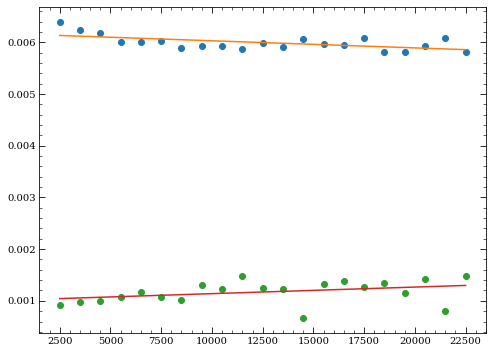

In [42]:
plt.plot(vals, alpha_arr, marker='o', ls='none')
cf1 = jl_poly_fit(vals, alpha_arr, robust_fit=True)
plt.plot(vals, jl_poly(vals, cf1))

plt.plot(vals, ppc_arr, marker='o', ls='none')
cf2 = jl_poly_fit(vals, ppc_arr, robust_fit=True)
plt.plot(vals, jl_poly(vals, cf2))

alpha = k_ipc[0,1]
_alpha = np.std(alpha_arr - jl_poly(vals, cf1))

ppc = k_ppc[1,2]
_ppc = np.std(ppc_arr - jl_poly(vals, cf2))


print('IPC = {:.3f}% +/- {:.3f}%'.format(alpha*100, _alpha*100))
print('PPC = {:.3f}% +/- {:.3f}%'.format(ppc*100, _ppc*100))

In [112]:
masks_dict.keys()

dict_keys(['mask_ref', 'mask_poly', 'mask_deviant', 'mask_negative', 'mask_others'])

In [123]:
mask_poly = masks_dict['mask_poly'].sum(axis=0) >= masks_dict['mask_poly'].shape[0]/2

In [124]:
len(mask_poly[~mask_poly])

41340

In [125]:
len(masks_dict['mask_poly'])

35

In [147]:
tint = tarr.max()
boxsize=5
nchans=4
bg_remove=False
hotcut=[10000,50000]
calc_ppc=False
same_scan_direction=False
reverse_scan_direction=False

imtemp = imdark * tint

boxhalf = int(boxsize/2)
boxsize = int(2*boxhalf + 1)
distmin = np.ceil(np.sqrt(2.0) * boxhalf)

# Get rid of pixels around border
pixmask = ((imtemp>hotcut[0]) & (imtemp<hotcut[1]))
pixmask[0:4+boxhalf, :] = False
pixmask[-4-boxhalf:, :] = False
pixmask[:, 0:4+boxhalf] = False
pixmask[:, -4-boxhalf:] = False

# Exclude pixels that aren't well fit by a polynomial
pixmask[~mask_poly] = False

# Ignore borders between amplifiers
for ch in range(1, nchans):
    x1 = ch*chsize - boxhalf
    x2 = x1 + 2*boxhalf
    pixmask[:, x1:x2] = False
indy, indx = np.where(pixmask)
nhot = len(indy)
if nhot < 2:
    print("No hot pixels found!")

# Only want isolated pixels
# Get distances for every pixel
# If too close, then set equal to 0
for i in range(nhot):
    d = np.sqrt((indx-indx[i])**2 + (indy-indy[i])**2)
    ind_close = np.where((d>0) & (d<distmin))[0]
    if len(ind_close)>0: pixmask[indy[i], indx[i]] = 0
indy, indx = np.where(pixmask)
nhot = len(indy)
if nhot < 2:
    print("No hot pixels found!")


In [148]:
print(nhot)

194


In [149]:
print(indy[0], indx[0])

62 783


1087 797


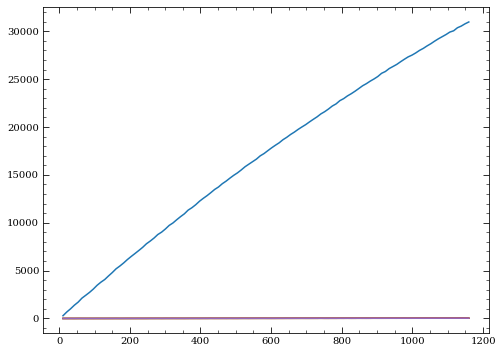

In [152]:
i=100

print(indy[i], indx[i])

plt.plot(tarr, super_dark_ramp[:,indy[i], indx[i]])
plt.plot(tarr, super_dark_ramp[:,indy[i], indx[i]+1])# + super_bias[indy[i], indx[i]+1])
plt.plot(tarr, super_dark_ramp[:,indy[i]+1, indx[i]])
plt.plot(tarr, super_dark_ramp[:,indy[i], indx[i]-1])
plt.plot(tarr, super_dark_ramp[:,indy[i]-1, indx[i]])


In [153]:
# Stack all hot pixels in a cube
hot_all = []
for iy, ix in zip(indy, indx):
    x1, y1 = np.array([ix,iy]) - boxhalf
    x2, y2 = np.array([x1,y1]) + boxsize
    sub = imtemp[y1:y2, x1:x2]

    # Flip channels along x-axis for PPC
    if calc_ppc:
        # Check if an even or odd channel (index 0)
        for ch in np.arange(0,nchans,2):
            even = True if (ix > ch*chsize) and (ix < (ch+1)*chsize-1) else False

        if same_scan_direction:
            flip = True if reverse_scan_direction else False
        elif even:
            flip = True if reverse_scan_direction else False
        else:
            flip = False if reverse_scan_direction else True

        if flip: sub = sub[:,::-1]

    hot_all.append(sub)
hot_all = np.array(hot_all)

In [154]:
norm_all = hot_all.copy()
for im in norm_all:
    im /= im[boxhalf-1:boxhalf+2, boxhalf-1:boxhalf+2].sum()


In [155]:
ipc_im_avg = np.median(norm_all, axis=0)

In [156]:
ipc_im_avg[1:4,1:4]

array([[1.59106629e-05, 3.06256118e-04, 3.05614137e-06],
       [3.23763344e-04, 9.98680628e-01, 3.26053608e-04],
       [8.15281784e-06, 3.06169441e-04, 1.26171228e-05]])

In [157]:
ipc_val = (ipc_im_avg[boxhalf-1,boxhalf] + \
          ipc_im_avg[boxhalf,boxhalf-1] + \
          ipc_im_avg[boxhalf+1,boxhalf]) / 3

In [158]:
ipc_val

0.0003120629677572378

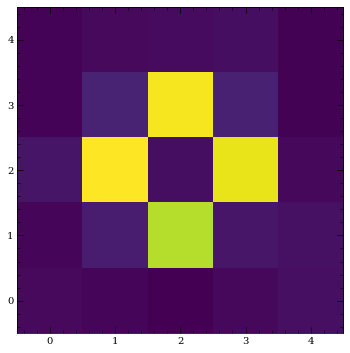

In [103]:
i = 2
im = ipc_im_avg
im[2,2] = 0
plt.imshow(im)

## Measurements

 1. Even/Odd column offsets (fixed)
 1. Reference drift over time
 1. Preamp reset noise
 1. 1/f Noise
     1. Pixel-based
     1. Spatially correlated across channels
     1. Spatially uncorrelated per channel
 1. kTC Noise
     1. Active
     1. Reference (ratio of two?)
 1. Read noise
     1. Active
     1. Active/Ref ratio
 1. IPC
